# 전압 루프만 돌기

In [ ]:
import pyvisa
import pandas as pd
import time
from datetime import datetime

VOLTAGE_STEPS = [264, 90]
FREQUENCY = 50
DWELL = 300
CURRENT_LIMIT = 18
MEASURE_INTERVAL = 5

rm = pyvisa.ResourceManager()
try:
    
    supply = rm.open_resource('COM5')
    supply.baud_rate = 9600  # 필요시 설정
except Exception as e:
    print(f"장비 연결 실패: {e}")
    exit()

supply.write('*RST')
time.sleep(1)
supply.write('AR 0')

results = []

for i, volt in enumerate(VOLTAGE_STEPS, start=1):
    print(f"\n Step {i}: {volt}V {FREQUENCY}Hz {DWELL}s 설정 및 실행")
    supply.write('STEPS 1')
    supply.write('EDIT 1')
    supply.write(f'VOLT {volt}')
    supply.write(f'FREQ {FREQUENCY}')
    supply.write(f'DWELL {DWELL}')
    supply.write(f'AHI {CURRENT_LIMIT}')
    supply.write('SAVE')
    supply.write('END')
    supply.write('TEST')
    start = time.time()
    while time.time() - start < DWELL:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        try:
            raw = supply.query('TD?').strip()
            fields = raw.split(',')
            # 실제 응답 포맷에 맞게 인덱스 조정 필요
            step_no = int(fields[0])
            status = fields[2]
            voltage = float(fields[3])
            freq = float(fields[4])
            current = float(fields[5])
            power = float(fields[6])
            peak_current = float(fields[7])
            pf = float(fields[8])
            timer = int(fields[9])
            results.append({
                'Time': timestamp,
                'Step': i,
                '전압': voltage,
                '전류': current,
                'Power': power,
                'PeakCurrent': peak_current,
                'PowerFactor': pf,
                'Elapsed': timer
            })
            print(f"[{timestamp}] Step {i} | V={voltage:.2f}V, I={current:.2f}A, P={power:.2f}W, PF={pf:.2f}")
        except Exception as e:
            print(f"TD? 파싱 오류: {raw} / {e}")
        time.sleep(MEASURE_INTERVAL)

df = pd.DataFrame(results)
filename = f"apt6020_step_test_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
df.to_csv(filename, index=False)
print(f"저장 완료: {filename}")

In [ ]:
df

# power supply , power analyzer , 온도 측정

In [ ]:
import pyvisa
import pandas as pd
import time
from datetime import datetime
from time import sleep

# 설정
voltages = [60.0, 90.0]   
wait_time = 300           # 5분
current_limit = 18.0      # 최대 전류 제한
frequency = 60.0          # 주파수
MEASURE_INTERVAL = 5      # 측정 간격 

# 장비연결
rm = pyvisa.ResourceManager()
supply = rm.open_resource('')     # APT6020
analyzer = rm.open_resource('')   # Power Analyzer
temp_meter = rm.open_resource('')  # 온도 센서 
#load = rm.open_resource('')       # 전자부하 ex) ITECH IT8511+

# 초기화
supply.write('*RST')
supply.write('AR 0')    # Program mode

results = []

# 전압 루프
for i, voltage in enumerate(voltages, start=1):
    print(f"\n설정 전압: {voltage}V, 유지 시간: {wait_time}초")

    # 스텝 구성
    supply.write('STEPS 1')
    supply.write('EDIT 1')
    supply.write(f'VOLT {voltage:.1f}')
    supply.write(f'FREQ {frequency:.1f}')
    supply.write(f'DWELL {wait_time}')
    supply.write(f'AHI {current_limit:.1f}')
    supply.write('SAVE')
    supply.write('END')
    # 전기 부하 설정
    #load.write("MODE CC") #정전류 모드? 모르겠음
    #load_current = 2.0 
    #load.write(f"CURR {load_current}")
    #load.write("INPUT ON") #부하 입력 시작

    # 테스트 실행
    supply.write('TEST')
    start_time = time.time()

    while time.time() - start_time < wait_time:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # 온도 측정
        temp_meter.write('READ?') # 명령어 확인(틀릴 수도 있음)
        temperature = float(temp_meter.read().strip())

        # 전력 측정 (Power Analyzer) , 명령어 확인
        voltage_meas = float(analyzer.query('MEAS:VOLT?').strip()) #전압
        current_meas = float(analyzer.query('MEAS:CURR?').strip()) # 전류
        power_meas = float(analyzer.query('MEAS:POW?').strip()) # 유효 전력

        # 로그 출력
        print(f"[{timestamp}] V={voltage_meas:.2f}V, I={current_meas:.2f}A, P={power_meas:.2f}W, T={temperature:.2f}°C")

        results.append({
            'Time': timestamp,
            'Set_V': voltage,
            'Meas_V': voltage_meas,
            'Current': current_meas,
            'Power': power_meas,
            'Temperature': temperature
        })

        #load.write("INPUT OFF") #여기가 맞는지 모르겠음
        sleep(MEASURE_INTERVAL)

    
    sleep(2)  # 대기

# 결과
df = pd.DataFrame(results)
# filename = f"측정_test_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
# df.to_csv(filename, index=False)



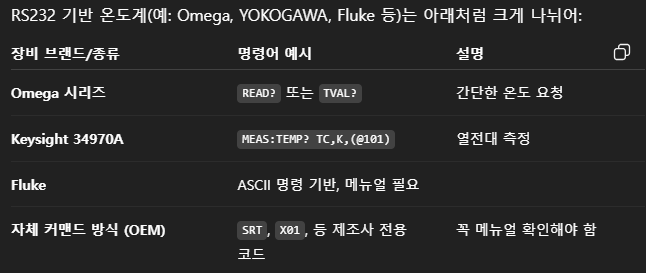

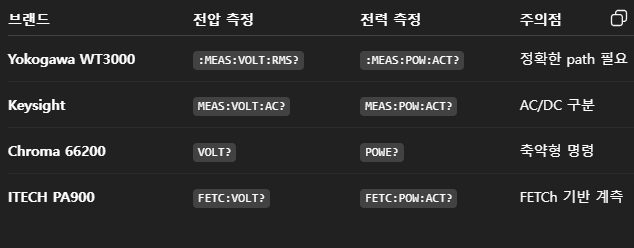

# 기본코드

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pyvisa
import serial
import socket
import threading
import csv
import time
from datetime import datetime

class PowerAnalyzerGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("통합 테스트 시스템")
        self.connection_type = {}
        self.instrument = {}
        self.csv_file = None
        self.csv_writer = None
        self.is_testing = False
        self.test_thread = None
        self.rm = pyvisa.ResourceManager()
        self.build_gui()

    def build_gui(self):
        labels = ["Power Supply", "Electronic Load", "온도 센서"]
        self.device_entries = {}
        for i, label in enumerate(labels):
            tk.Label(self.root, text=label).grid(row=i, column=0)
            entry = tk.Entry(self.root, width=40)
            entry.grid(row=i, column=1, columnspan=3)
            self.device_entries[label] = entry
        self.connect_btn = tk.Button(self.root, text="장비 연결", command=self.connect_all)
        self.connect_btn.grid(row=0, column=4, rowspan=3, sticky="ns")
        tk.Label(self.root, text="전압 시퀀스 설정 (V):").grid(row=3, column=0)
        self.voltage_entry = tk.Entry(self.root, width=30)
        self.voltage_entry.grid(row=3, column=1)
        self.voltage_entry.insert(0, "60,90")
        tk.Label(self.root, text="대기 시간 (s):").grid(row=4, column=0)
        self.wait_entry = tk.Entry(self.root, width=10)
        self.wait_entry.grid(row=4, column=1)
        self.wait_entry.insert(0, "300")
        tk.Label(self.root, text="샘플링 간격 (s):").grid(row=5, column=0)
        self.sampling_entry = tk.Entry(self.root, width=10)
        self.sampling_entry.grid(row=5, column=1)
        self.sampling_entry.insert(0, "5")
        self.start_test_btn = tk.Button(self.root, text="테스트 시작", command=self.start_test)
        self.start_test_btn.grid(row=6, column=0, columnspan=2)
        self.log_box = tk.Text(self.root, height=15, width=100)
        self.log_box.grid(row=7, column=0, columnspan=5)

    def log(self, text):
        def append_log():
            timestamp = time.strftime("%H:%M:%S")
            self.log_box.insert(tk.END, f"[{timestamp}] {text}\n")
            self.log_box.see(tk.END)
        self.root.after(0, append_log)

    def connect_all(self):
        for label, entry in self.device_entries.items():
            address = entry.get().strip()
            try:
                if address.upper().startswith("USB") or "::" in address:
                    inst = self.rm.open_resource(address)
                    inst.timeout = 3000
                    inst.query("*IDN?")
                    self.instrument[label] = inst
                    self.connection_type[label] = "VISA"
                    self.log(f"{label} 연결 성공 (VISA)")
                elif address.upper().startswith("COM"):
                    ser = serial.Serial(address, baudrate=9600, timeout=3)
                    self.instrument[label] = ser
                    self.connection_type[label] = "SERIAL"
                    self.log(f"{label} 연결 성공 (SERIAL)")
                elif ":" in address:
                    ip, port = address.split(":")
                    sock = socket.create_connection((ip, int(port)), timeout=3)
                    self.instrument[label] = sock
                    self.connection_type[label] = "LAN"
                    self.log(f"{label} 연결 성공 (LAN)")
                else:
                    raise ValueError("주소 형식을 인식할 수 없음.")
            except Exception as e:
                self.log(f"{label} 연결 실패: {e}")

    def write(self, label, command):
        try:
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            if conn_type == "VISA":
                inst.write(command)
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
        except Exception as e:
            self.log(f"{label} 명령 전송 오류: {e}")

    def query(self, label, command):
        try:
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            if conn_type == "VISA":
                return inst.query(command).strip()
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())
                time.sleep(0.3)
                return inst.readline().decode().strip()
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                return inst.recv(1024).decode().strip()
        except Exception as e:
            self.log(f"{label} 쿼리 오류: {e}")
            return "ERROR"

    def start_test(self):
        for label in ["Power Supply", "Electronic Load", "온도 센서"]:
            if label not in self.instrument:
                self.log(f"{label}가 연결되지 않았습니다.")
                messagebox.showerror("연결 오류", f"{label}가 연결되지 않았습니다.")
                return
        try:
            voltages = [float(v.strip()) for v in self.voltage_entry.get().split(",") if v.strip()]
            if not voltages:
                raise ValueError("전압 시퀀스를 입력.")
            wait_time = float(self.wait_entry.get())
            sampling_interval = float(self.sampling_entry.get())
            if wait_time <= 0 or sampling_interval <= 0:
                raise ValueError("대기 시간과 샘플링 간격은 0보다 커야 합니다.")
        except Exception as e:
            self.log(f"입력값 오류: {e}")
            messagebox.showerror("입력값 오류", str(e))
            return
        self.voltages = voltages
        self.wait_time = wait_time
        self.sampling_interval = sampling_interval
        self.open_log_file()
        self.is_testing = True
        self.test_thread = threading.Thread(target=self.run_test_sequence, daemon=True)
        self.test_thread.start()

    def open_log_file(self):
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        self.csv_file = open(f"result_{timestamp}.csv", "w", newline="")
        self.csv_writer = csv.writer(self.csv_file)
        self.csv_writer.writerow(["Time", "Set_V", "Measured_V", "Current", "Power", "Temperature"])
        self.log("CSV 파일 생성 완료")

    def run_test_sequence(self):
        try:
            supply_label = "Power Supply"
            load_label = "Electronic Load"
            temp_label = "온도 센서"
            for v in self.voltages:
                self.log(f"전압 {v}V 설정 및 테스트 시작")
                try:
                    self.write(supply_label, "*RST")
                    time.sleep(1)
                    self.write(supply_label, "AR 1")
                    time.sleep(1)
                    self.write(supply_label, f"VOLT {v}")
                    time.sleep(1)
                    #self.write(supply_label, "CURR 2.0")
                    #time.sleep(1)
                    self.write(supply_label, "TEST") # test가 아니라 outp on으로 해야할 수도?
                    time.sleep(1)
                    #self.write(supply_label, "OUTP ON")  # 이 줄을 반드시 추가해야 실제 출력 시작됨
                    #time.sleep(1)
                except Exception as e:
                    self.log(f"Power Supply 명령 오류: {e}")
                    continue
                try:
                    self.write(load_label, ":MODE CC")  #:FUNC CURR
                    self.write(load_label, ":CURR 2.0")
                    self.write(load_label, ":LOAD ON")
                except Exception as e:
                    self.log(f"Electronic Load 명령 오류: {e}")
                    continue
                start_time = time.time()
                while time.time() - start_time < self.wait_time:
                    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    try:
                        
                        temperature = float(self.query(temp_label, ":VAL1:VAL?").strip())
                        voltage_meas = float(self.query(load_label, ":MEAS:VOLT?").strip())
                        current_meas = float(self.query(load_label, ":MEAS:CURR?").strip())
                        power_meas = float(self.query(load_label, ":MEAS:POW?").strip())
                        self.csv_writer.writerow([timestamp, v, voltage_meas, current_meas, power_meas, temperature])
                        self.csv_file.flush()
                        self.log(f"[{timestamp}] V={voltage_meas:.2f}, I={current_meas:.2f}, P={power_meas:.2f}, T={temperature:.2f}")
                    except Exception as e:
                        self.log(f"측정 오류: {e}")
                    time.sleep(self.sampling_interval)
                try:
                    self.write(load_label, ":LOAD OFF")
                    #self.write(supply_label, "OUTP OFF")
                    self.write(supply_label, "*RST")
                except Exception as e:
                    self.log(f"테스트 종료 명령 오류: {e}")
                time.sleep(2)
            self.log("모든 테스트 완료")
        except Exception as e:
            self.log(f"시퀀스 실행 중 오류: {e}")
        finally:
            self.is_testing = False
            if self.csv_file:
                self.csv_file.close()
                self.log("CSV 저장 완료")
            for label, inst in self.instrument.items():
                try:
                    if self.connection_type[label] == "VISA":
                        inst.close()
                    elif self.connection_type[label] == "SERIAL":
                        inst.close()
                    elif self.connection_type[label] == "LAN":
                        inst.close()
                except Exception:
                    pass

if __name__ == "__main__":
    root = tk.Tk()
    app = PowerAnalyzerGUI(root)
    root.mainloop()


# 기본코드에서 수정(장치 하나만 연결해도 가능하도록)

In [3]:
import tkinter as tk
from tkinter import messagebox
import pyvisa
import serial
import socket
import threading
import csv
import time
from datetime import datetime

class PowerAnalyzerGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("통합 테스트 시스템")
        self.connection_type = {}
        self.instrument = {}
        self.csv_file = None
        self.csv_writer = None
        self.is_testing = False
        self.test_thread = None
        self.rm = pyvisa.ResourceManager()
        self.build_gui()

    def build_gui(self):
        labels = ["Power Supply", "Electronic Load", "온도 센서"]
        self.device_entries = {}
        for i, label in enumerate(labels):
            tk.Label(self.root, text=label).grid(row=i, column=0)
            entry = tk.Entry(self.root, width=40)
            entry.grid(row=i, column=1, columnspan=3)
            self.device_entries[label] = entry
        self.connect_btn = tk.Button(self.root, text="장비 연결", command=self.connect_all)
        self.connect_btn.grid(row=0, column=4, rowspan=3, sticky="ns")
        tk.Label(self.root, text="전압 시퀀스 설정 (V):").grid(row=3, column=0)
        self.voltage_entry = tk.Entry(self.root, width=30)
        self.voltage_entry.grid(row=3, column=1)
        self.voltage_entry.insert(0, "60,90")
        tk.Label(self.root, text="대기 시간 (s):").grid(row=4, column=0)
        self.wait_entry = tk.Entry(self.root, width=10)
        self.wait_entry.grid(row=4, column=1)
        self.wait_entry.insert(0, "300")
        tk.Label(self.root, text="샘플링 간격 (s):").grid(row=5, column=0)
        self.sampling_entry = tk.Entry(self.root, width=10)
        self.sampling_entry.grid(row=5, column=1)
        self.sampling_entry.insert(0, "5")
        self.start_test_btn = tk.Button(self.root, text="테스트 시작", command=self.start_test)
        self.start_test_btn.grid(row=6, column=0, columnspan=2)
        self.log_box = tk.Text(self.root, height=15, width=100)
        self.log_box.grid(row=7, column=0, columnspan=5)

    def log(self, text):
        def append_log():
            timestamp = time.strftime("%H:%M:%S")
            self.log_box.insert(tk.END, f"[{timestamp}] {text}\n")
            self.log_box.see(tk.END)
        self.root.after(0, append_log)

    def connect_all(self):
        for label, entry in self.device_entries.items():
            address = entry.get().strip()
            if not address:
                continue
            try:
                if address.upper().startswith("USB") or "::" in address:
                    inst = self.rm.open_resource(address)
                    inst.timeout = 3000
                    inst.query("*IDN?")
                    self.instrument[label] = inst
                    self.connection_type[label] = "VISA"
                    self.log(f"{label} 연결 성공 (VISA)")
                elif address.upper().startswith("COM"):
                    ser = serial.Serial(address, baudrate=9600, timeout=3)
                    self.instrument[label] = ser
                    self.connection_type[label] = "SERIAL"
                    self.log(f"{label} 연결 성공 (SERIAL)")
                elif ":" in address:
                    ip, port = address.split(":")
                    sock = socket.create_connection((ip, int(port)), timeout=3)
                    self.instrument[label] = sock
                    self.connection_type[label] = "LAN"
                    self.log(f"{label} 연결 성공 (LAN)")
                else:
                    raise ValueError("주소 형식을 인식할 수 없음.")
            except Exception as e:
                self.log(f"{label} 연결 실패: {e}")

    def write(self, label, command):
        try:
            if label not in self.connection_type or label not in self.instrument:
                return
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            if conn_type == "VISA":
                inst.write(command)
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
        except Exception as e:
            self.log(f"{label} 명령 전송 오류: {e}")

    def query(self, label, command):
        try:
            if label not in self.connection_type or label not in self.instrument:
                return None
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            if conn_type == "VISA":
                return inst.query(command).strip()
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())
                time.sleep(0.3)
                return inst.readline().decode().strip()
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                return inst.recv(1024).decode().strip()
        except Exception as e:
            self.log(f"{label} 쿼리 오류: {e}")
            return None

    def start_test(self):
    # 연결된 장치가 최소 1개 이상인지 체크
        if not self.instrument:
            self.log("연결된 장치가 없습니다.")
            messagebox.showerror("연결 오류", "연결된 장치가 없습니다.")
            return

        # 기존 입력값 체크와 저장
        try:
            voltages = [float(v.strip()) for v in self.voltage_entry.get().split(",") if v.strip()]
            if not voltages:
                raise ValueError("전압 시퀀스를 입력하세요.")
            wait_time = float(self.wait_entry.get())
            sampling_interval = float(self.sampling_entry.get())
            if wait_time <= 0 or sampling_interval <= 0:
                raise ValueError("대기 시간과 샘플링 간격은 0보다 커야 합니다.")
        except Exception as e:
            self.log(f"입력값 오류: {e}")
            messagebox.showerror("입력값 오류", str(e))
            return

        self.voltages = voltages
        self.wait_time = wait_time
        self.sampling_interval = sampling_interval

        self.open_log_file()
        self.is_testing = True
        self.test_thread = threading.Thread(target=self.run_test_sequence, daemon=True)
        self.test_thread.start()

    def open_log_file(self):
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        self.csv_file = open(f"result_{timestamp}.csv", "w", newline="")
        self.csv_writer = csv.writer(self.csv_file)
        self.csv_writer.writerow(["Time", "Set_V", "Measured_V", "Current", "Power", "Temperature", "Supply_v"])
        self.log("CSV 파일 생성 완료")

    def run_test_sequence(self):
        try:
            supply_label = "Power Supply"
            load_label = "Electronic Load"
            temp_label = "온도 센서"
            for v in self.voltages:
                self.log(f"전압 {v}V 설정 및 테스트 시작")
                time.sleep(0.5)
                # Power Supply 명령
                if supply_label in self.instrument:
                    try:
                        self.write(supply_label, "*RST")
                        time.sleep(1)
                        self.write(supply_label, "AR 1")
                        time.sleep(1)
                        self.write(supply_label, f"VOLT {v}")
                        time.sleep(1)
                        self.write(supply_label, "TEST") # 필요시 OUTP ON 등으로 변경
                        time.sleep(1)
                    except Exception as e:
                        self.log(f"Power Supply 명령 오류: {e}")
                        #continue
                # Electronic Load 명령
                if load_label in self.instrument:
                    try:
                        self.write(load_label, ":MODE CC")
                        self.write(load_label, ":CURR 11.0")
                        self.write(load_label, ":LOAD ON")
                    except Exception as e:
                        self.log(f"Electronic Load 명령 오류: {e}")
                        #continue

                start_time = time.time()
                while time.time() - start_time < self.wait_time:
                    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    # 초기값
                    supply_v = temperature = voltage_meas = current_meas = power_meas = "N/A"
                    # 연결된 장비만 쿼리
                    try:
                        if supply_label in self.instrument:
                            val = self.query(supply_label, "TDVOLT?")
                            if val is not None:
                                supply_v = float(val)
                        if temp_label in self.instrument:
                            val = self.query(temp_label, ":VAL1:VAL?")
                            if val is not None:
                                temperature = float(val)
                        if load_label in self.instrument:
                            val_v = self.query(load_label, ":MEAS:VOLT?")
                            val_c = self.query(load_label, ":MEAS:CURR?")
                            val_p = self.query(load_label, ":MEAS:POW?")
                            if val_v is not None:
                                voltage_meas = float(val_v)
                            if val_c is not None:
                                current_meas = float(val_c)
                            if val_p is not None:
                                power_meas = float(val_p)
                    except Exception as e:
                        self.log(f"측정 오류: {e}")

                    self.csv_writer.writerow([timestamp, v, voltage_meas, current_meas, power_meas, temperature])
                    self.csv_file.flush()
                    self.log(f"[{timestamp}] V={voltage_meas}, I={current_meas}, P={power_meas}, T={temperature}")

                # 종료 명령 (연결된 장비만)
                if load_label in self.instrument:
                    try:
                        self.write(load_label, ":LOAD OFF")
                    except Exception as e:
                        self.log(f"Electronic Load 종료 명령 오류: {e}")
                if supply_label in self.instrument:
                    try:
                        self.write(supply_label, "*RST")
                    except Exception as e:
                        self.log(f"Power Supply 종료 명령 오류: {e}")
                time.sleep(2)
            self.log("모든 테스트 완료")
        except Exception as e:
            self.log(f"시퀀스 실행 중 오류: {e}")
        finally:
            self.is_testing = False
            if self.csv_file:
                self.csv_file.close()
                self.log("CSV 저장 완료")
            for label, inst in self.instrument.items():
                try:
                    if self.connection_type[label] == "VISA":
                        inst.close()
                    elif self.connection_type[label] == "SERIAL":
                        inst.close()
                    elif self.connection_type[label] == "LAN":
                        inst.close()
                except Exception:
                    pass

if __name__ == "__main__":
    root = tk.Tk()
    app = PowerAnalyzerGUI(root)
    root.mainloop()


# 수정(테스트 정지)

In [2]:
import tkinter as tk
from tkinter import messagebox
import pyvisa
import serial
import socket
import threading
import csv
import time
from datetime import datetime

class PowerAnalyzerGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("통합 테스트 시스템")
        self.connection_type = {}
        self.instrument = {}
        self.csv_file = None
        self.csv_writer = None
        self.is_testing = False
        self.test_thread = None
        self.rm = pyvisa.ResourceManager()
        self.build_gui()

    def build_gui(self):
        labels = ["Power Supply", "Electronic Load", "온도 센서"]
        self.device_entries = {}
        for i, label in enumerate(labels):
            tk.Label(self.root, text=label).grid(row=i, column=0, padx=5, pady=5, sticky="w")
            entry = tk.Entry(self.root, width=40)
            entry.grid(row=i, column=1, columnspan=3, padx=5, pady=5)
            self.device_entries[label] = entry
        
        self.connect_btn = tk.Button(self.root, text="장비 연결", command=self.connect_all)
        self.connect_btn.grid(row=0, column=4, rowspan=3, sticky="ns", padx=5, pady=5)
        
        tk.Label(self.root, text="전압 시퀀스 설정 (V):").grid(row=3, column=0, padx=5, pady=5, sticky="w")
        self.voltage_entry = tk.Entry(self.root, width=30)
        self.voltage_entry.grid(row=3, column=1, padx=5, pady=5)
        self.voltage_entry.insert(0, "60,90")
        
        tk.Label(self.root, text="대기 시간 (s):").grid(row=4, column=0, padx=5, pady=5, sticky="w")
        self.wait_entry = tk.Entry(self.root, width=10)
        self.wait_entry.grid(row=4, column=1, padx=5, pady=5, sticky="w")
        self.wait_entry.insert(0, "60")
        
        tk.Label(self.root, text="샘플링 간격 (s):").grid(row=5, column=0, padx=5, pady=5, sticky="w")
        self.sampling_entry = tk.Entry(self.root, width=10)
        self.sampling_entry.grid(row=5, column=1, padx=5, pady=5, sticky="w")
        self.sampling_entry.insert(0, "5")
        
        # 테스트 제어 버튼들
        button_frame = tk.Frame(self.root)
        button_frame.grid(row=6, column=0, columnspan=5, pady=10)
        
        self.start_test_btn = tk.Button(button_frame, text="테스트 시작", command=self.start_test)
        self.start_test_btn.pack(side=tk.LEFT, padx=5)
        
        self.stop_test_btn = tk.Button(button_frame, text="테스트 중지", command=self.stop_test, state=tk.DISABLED)
        self.stop_test_btn.pack(side=tk.LEFT, padx=5)
        
        # 연결 상태 표시
        self.status_label = tk.Label(self.root, text="연결 상태: 대기 중", bg="lightgray")
        self.status_label.grid(row=7, column=0, columnspan=5, sticky="ew", padx=5, pady=5)
        
        # 로그 박스
        self.log_box = tk.Text(self.root, height=15, width=100)
        self.log_box.grid(row=8, column=0, columnspan=5, padx=5, pady=5)
        
        # 스크롤바 추가
        scrollbar = tk.Scrollbar(self.root, command=self.log_box.yview)
        scrollbar.grid(row=8, column=5, sticky="ns", pady=5)
        self.log_box.config(yscrollcommand=scrollbar.set)

    def log(self, text):
        def append_log():
            timestamp = time.strftime("%H:%M:%S")
            self.log_box.insert(tk.END, f"[{timestamp}] {text}\n")
            self.log_box.see(tk.END)
            # 로그가 너무 많이 쌓이면 오래된 것 삭제
            if int(self.log_box.index('end-1c').split('.')[0]) > 1000:
                self.log_box.delete('1.0', '100.0')
        self.root.after(0, append_log)

    def update_status(self, text, color="lightgray"):
        def update():
            self.status_label.config(text=f"연결 상태: {text}", bg=color)
        self.root.after(0, update)

    def connect_all(self):
        self.update_status("연결 중...", "yellow")
        connected_count = 0
        
        for label, entry in self.device_entries.items():
            address = entry.get().strip()
            if not address:
                self.log(f"{label} 주소가 입력되지 않았습니다.")
                continue
                
            try:
                if address.upper().startswith("USB") or "::" in address:
                    inst = self.rm.open_resource(address)
                    inst.timeout = 5000  # 타임아웃 증가
                    response = inst.query("*IDN?")
                    self.instrument[label] = inst
                    self.connection_type[label] = "VISA"
                    self.log(f"{label} 연결 성공 (VISA) - {response.strip()}")
                    connected_count += 1
                elif address.upper().startswith("COM"):
                    ser = serial.Serial(address, baudrate=9600, timeout=5)
                    time.sleep(0.5)  # 시리얼 연결 안정화
                    self.instrument[label] = ser
                    self.connection_type[label] = "SERIAL"
                    self.log(f"{label} 연결 성공 (SERIAL)")
                    connected_count += 1
                elif ":" in address and not "::" in address:
                    try:
                        ip, port = address.split(":")
                        sock = socket.create_connection((ip, int(port)), timeout=5)
                        self.instrument[label] = sock
                        self.connection_type[label] = "LAN"
                        self.log(f"{label} 연결 성공 (LAN)")
                        connected_count += 1
                    except ValueError:
                        raise ValueError("IP:Port 형식이 올바르지 않습니다.")
                else:
                    raise ValueError("주소 형식을 인식할 수 없습니다. (USB, COM, IP:Port 형식 지원)")
                    
            except Exception as e:
                self.log(f"{label} 연결 실패: {e}")
                # 연결 실패한 경우 정리
                if label in self.instrument:
                    try:
                        self.instrument[label].close()
                    except:
                        pass
                    del self.instrument[label]
                if label in self.connection_type:
                    del self.connection_type[label]
        
        if connected_count == len(self.device_entries):
            self.update_status("모든 장비 연결됨", "lightgreen")
        elif connected_count > 0:
            self.update_status(f"{connected_count}/{len(self.device_entries)} 장비 연결됨", "orange")
        else:
            self.update_status("연결 실패", "lightcoral")

    def write(self, label, command):
        try:
            if label not in self.instrument:
                raise Exception(f"{label}가 연결되지 않음")
                
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            
            if conn_type == "VISA":
                inst.write(command)
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())  # \r\n으로 변경
                inst.flush()
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                
        except Exception as e:
            self.log(f"{label} 명령 전송 오류: {e}")
            raise

    def query(self, label, command):
        try:
            if label not in self.instrument:
                raise Exception(f"{label}가 연결되지 않음")
                
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            
            if conn_type == "VISA":
                return inst.query(command).strip()
            elif conn_type == "SERIAL":
                inst.flushInput()  # 입력 버퍼 클리어
                inst.write((command + "\n").encode())
                inst.flush()
                time.sleep(0.5)  # 응답 대기 시간 증가
                response = inst.readline().decode().strip()
                return response
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                response = inst.recv(1024).decode().strip()
                return response
                
        except Exception as e:
            self.log(f"{label} 쿼리 오류: {e}")
            return "ERROR"

    def stop_test(self):
        """테스트 중지 함수"""
        self.is_testing = False
        self.log("테스트 중지 요청됨")
        self.start_test_btn.config(state=tk.NORMAL)
        self.stop_test_btn.config(state=tk.DISABLED)

    def start_test(self):
        # 필수 장비 연결 확인
        required_devices = ["Power Supply", "Electronic Load", "온도 센서"]
        for label in required_devices:
            if label not in self.instrument:
                self.log(f"{label}가 연결되지 않았습니다.")
                messagebox.showerror("연결 오류", f"{label}가 연결되지 않았습니다.")
                return
        
        # 입력값 검증
        try:
            voltage_text = self.voltage_entry.get().strip()
            if not voltage_text:
                raise ValueError("전압 시퀀스를 입력하세요.")
            voltages = [float(v.strip()) for v in voltage_text.split(",") if v.strip()]
            if not voltages:
                raise ValueError("유효한 전압값을 입력하세요.")
            
            wait_time = float(self.wait_entry.get())
            sampling_interval = float(self.sampling_entry.get())
            
            if wait_time <= 0 or sampling_interval <= 0:
                raise ValueError("대기 시간과 샘플링 간격은 0보다 커야 합니다.")
            if sampling_interval >= wait_time:
                raise ValueError("샘플링 간격은 대기 시간보다 작아야 합니다.")
                
        except ValueError as e:
            self.log(f"입력값 오류: {e}")
            messagebox.showerror("입력값 오류", str(e))
            return
        except Exception as e:
            self.log(f"예상치 못한 오류: {e}")
            messagebox.showerror("오류", str(e))
            return
        
        self.voltages = voltages
        self.wait_time = wait_time
        self.sampling_interval = sampling_interval
        
        if not self.open_log_file():
            return
            
        self.is_testing = True
        self.start_test_btn.config(state=tk.DISABLED)
        self.stop_test_btn.config(state=tk.NORMAL)
        
        self.test_thread = threading.Thread(target=self.run_test_sequence, daemon=True)
        self.test_thread.start()

    def open_log_file(self):
        try:
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            filename = f"result_{timestamp}.csv"
            self.csv_file = open(filename, "w", newline="", encoding="utf-8")
            self.csv_writer = csv.writer(self.csv_file)
            self.csv_writer.writerow(["Time", "Set_V", "Measured_V", "Current", "Power", "Temperature"])
            self.csv_file.flush()
            self.log(f"CSV 파일 생성 완료: {filename}")
            return True
        except Exception as e:
            self.log(f"CSV 파일 생성 오류: {e}")
            messagebox.showerror("파일 오류", f"CSV 파일을 생성할 수 없습니다: {e}")
            return False

    def run_test_sequence(self):
        try:
            supply_label = "Power Supply"
            load_label = "Electronic Load"
            temp_label = "온도 센서"
            
            self.log(f"테스트 시퀀스 시작 - 전압: {self.voltages}V")
            
            for voltage_idx, v in enumerate(self.voltages):
                if not self.is_testing:
                    self.log("테스트가 중지되었습니다.")
                    break
                    
                self.log(f"전압 {v}V 설정 및 테스트 시작 ({voltage_idx+1}/{len(self.voltages)})")
                
                try:
                    # Power Supply 설정
                    self.write(supply_label, "*RST")
                    time.sleep(2)
                    self.write(supply_label, "AR 1")
                    time.sleep(1)
                    self.write(supply_label, f"VOLT {v}")
                    time.sleep(1)
                    #self.write(supply_label, "CURR 2.0")
                    #time.sleep(1)
                    self.write(supply_label, "TEST") # test가 아니라 outp on으로 해야할 수도?
                    time.sleep(1)
                    # self.write(supply_label, "VOLT:LEV:IMM:AMPL " + str(v))  # 표준 SCPI 명령 사용
                    # time.sleep(1)
                    # self.write(supply_label, "CURR:LEV:IMM:AMPL 5.0")  # 전류 제한 설정
                    # time.sleep(1)
                    # self.write(supply_label, "OUTP ON")  # 출력 켜기
                    # time.sleep(2)
                    
                    self.log(f"Power Supply 설정 완료: {v}V")
                    
                except Exception as e:
                    self.log(f"Power Supply 설정 오류: {e}")
                    continue
                
                try:
                    # Electronic Load 설정
                    self.write(load_label, ":MODE CC")
                    time.sleep(0.5)
                    self.write(load_label, ":CURR 2.0")
                    time.sleep(0.5)
                    self.write(load_label, ":LOAD ON")
                    time.sleep(1)
                    
                    self.log("Electronic Load 설정 완료: CC 2.0A")
                    
                except Exception as e:
                    self.log(f"Electronic Load 설정 오류: {e}")
                    continue
                
                # 데이터 수집 시작
                start_time = time.time()
                sample_count = 0
                
                while (time.time() - start_time < self.wait_time) and self.is_testing:
                    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    
                    try:
                        # 측정값 읽기
                        voltage_meas = float(self.query(load_label, ":MEAS:VOLT?"))
                        current_meas = float(self.query(load_label, ":MEAS:CURR?"))
                        power_meas = float(self.query(load_label, ":MEAS:POW?"))
                        
                        # 온도 센서 읽기
                        temp_response = self.query(temp_label, ":VAL1:VAL?")
                        try:
                            temperature = float(temp_response)
                        except:
                            temperature = 0.0  # 온도 읽기 실패시 기본값
                            self.log(f"온도 읽기 실패: {temp_response}")
                        
                        # CSV에 데이터 저장
                        self.csv_writer.writerow([timestamp, v, voltage_meas, current_meas, power_meas, temperature])
                        self.csv_file.flush()
                        
                        sample_count += 1
                        elapsed_time = int(time.time() - start_time)
                        remaining_time = int(self.wait_time - elapsed_time)
                        
                        self.log(f"[{sample_count:03d}] V={voltage_meas:.2f}V, I={current_meas:.2f}A, P={power_meas:.2f}W, T={temperature:.1f}°C (남은시간: {remaining_time}s)")
                        
                    except Exception as e:
                        self.log(f"측정 오류: {e}")
                    
                    time.sleep(self.sampling_interval)
                
                # 각 전압 단계 완료 후 정리
                try:
                    self.write(load_label, ":LOAD OFF")
                    time.sleep(1)
                    self.write(supply_label, "*RST")
                    time.sleep(2)
                    self.log(f"전압 {v}V 테스트 완료")
                    
                except Exception as e:
                    self.log(f"테스트 종료 명령 오류: {e}")
                
                # 다음 전압으로 넘어가기 전 대기
                if voltage_idx < len(self.voltages) - 1:
                    time.sleep(5)
            
            if self.is_testing:
                self.log("모든 전압 시퀀스 테스트 완료!")
            else:
                self.log("테스트가 사용자에 의해 중지되었습니다.")
                
        except Exception as e:
            self.log(f"시퀀스 실행 중 심각한 오류: {e}")
            
        finally:
            self.is_testing = False
            
            # 모든 장비 출력 끄기
            try:
                if "Electronic Load" in self.instrument:
                    self.write("Electronic Load", ":LOAD OFF")
                if "Power Supply" in self.instrument:
                    # self.write("Power Supply", "OUTP OFF")
                    self.write("Power Supply", "*RST")
            except Exception as e:
                self.log(f"장비 종료 명령 오류: {e}")
            
            # CSV 파일 닫기
            if self.csv_file:
                try:
                    self.csv_file.close()
                    self.log("CSV 파일 저장 완료")
                except Exception as e:
                    self.log(f"CSV 파일 저장 오류: {e}")
            
            # GUI 버튼 상태 복원
            self.root.after(0, lambda: (
                self.start_test_btn.config(state=tk.NORMAL),
                self.stop_test_btn.config(state=tk.DISABLED)
            ))
    
    def __del__(self):
       
        try:
            if hasattr(self, 'csv_file') and self.csv_file:
                self.csv_file.close()
            
            if hasattr(self, 'instrument'):
                for label, inst in self.instrument.items():
                    try:
                        if self.connection_type[label] == "VISA":
                            inst.close()
                        elif self.connection_type[label] == "SERIAL":
                            inst.close()
                        elif self.connection_type[label] == "LAN":
                            inst.close()
                    except Exception:
                        pass
            
            if hasattr(self, 'rm'):
                self.rm.close()
        except Exception:
            pass

if __name__ == "__main__":
    root = tk.Tk()
    app = PowerAnalyzerGUI(root)
    root.mainloop()

# 온도 센서가 연결되지 않은 경우

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pyvisa
import serial
import socket
import threading
import csv
import time
from datetime import datetime

class PowerAnalyzerGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("통합 테스트 시스템")
        self.connection_type = {}
        self.instrument = {}
        self.csv_file = None
        self.csv_writer = None
        self.is_testing = False
        self.test_thread = None
        self.rm = pyvisa.ResourceManager()
        self.build_gui()

    def build_gui(self):
        labels = ["Power Supply", "Electronic Load", "온도 센서"]
        self.device_entries = {}
        for i, label in enumerate(labels):
            tk.Label(self.root, text=label).grid(row=i, column=0, padx=5, pady=5, sticky="w")
            entry = tk.Entry(self.root, width=40)
            entry.grid(row=i, column=1, columnspan=3, padx=5, pady=5)
            self.device_entries[label] = entry
        
        self.connect_btn = tk.Button(self.root, text="장비 연결", command=self.connect_all)
        self.connect_btn.grid(row=0, column=4, rowspan=3, sticky="ns", padx=5, pady=5)
        
        tk.Label(self.root, text="전압 시퀀스 설정 (V):").grid(row=3, column=0, padx=5, pady=5, sticky="w")
        self.voltage_entry = tk.Entry(self.root, width=30)
        self.voltage_entry.grid(row=3, column=1, padx=5, pady=5)
        self.voltage_entry.insert(0, "60,90")
        
        tk.Label(self.root, text="대기 시간 (s):").grid(row=4, column=0, padx=5, pady=5, sticky="w")
        self.wait_entry = tk.Entry(self.root, width=10)
        self.wait_entry.grid(row=4, column=1, padx=5, pady=5, sticky="w")
        self.wait_entry.insert(0, "300")
        
        tk.Label(self.root, text="샘플링 간격 (s):").grid(row=5, column=0, padx=5, pady=5, sticky="w")
        self.sampling_entry = tk.Entry(self.root, width=10)
        self.sampling_entry.grid(row=5, column=1, padx=5, pady=5, sticky="w")
        self.sampling_entry.insert(0, "5")
        
        # 테스트 제어 버튼들
        button_frame = tk.Frame(self.root)
        button_frame.grid(row=6, column=0, columnspan=5, pady=10)
        
        self.start_test_btn = tk.Button(button_frame, text="테스트 시작", command=self.start_test)
        self.start_test_btn.pack(side=tk.LEFT, padx=5)
        
        self.stop_test_btn = tk.Button(button_frame, text="테스트 중지", command=self.stop_test, state=tk.DISABLED)
        self.stop_test_btn.pack(side=tk.LEFT, padx=5)
        
        # 연결 상태 표시
        self.status_label = tk.Label(self.root, text="연결 상태: 대기 중", bg="lightgray")
        self.status_label.grid(row=7, column=0, columnspan=5, sticky="ew", padx=5, pady=5)
        
        # 로그 박스
        self.log_box = tk.Text(self.root, height=15, width=100)
        self.log_box.grid(row=8, column=0, columnspan=5, padx=5, pady=5)
        
        # 스크롤바 추가
        scrollbar = tk.Scrollbar(self.root, command=self.log_box.yview)
        scrollbar.grid(row=8, column=5, sticky="ns", pady=5)
        self.log_box.config(yscrollcommand=scrollbar.set)

    def log(self, text):
        def append_log():
            timestamp = time.strftime("%H:%M:%S")
            self.log_box.insert(tk.END, f"[{timestamp}] {text}\n")
            self.log_box.see(tk.END)
            # 로그가 너무 많이 쌓이면 오래된 것 삭제
            if int(self.log_box.index('end-1c').split('.')[0]) > 1000:
                self.log_box.delete('1.0', '100.0')
        self.root.after(0, append_log)

    def update_status(self, text, color="lightgray"):
        def update():
            self.status_label.config(text=f"연결 상태: {text}", bg=color)
        self.root.after(0, update)

    def connect_all(self):
        self.update_status("연결 중...", "yellow")
        connected_count = 0
        
        for label, entry in self.device_entries.items():
            address = entry.get().strip()
            if not address:
                self.log(f"{label} 주소가 입력되지 않았습니다.")
                continue
                
            try:
                if address.upper().startswith("USB") or "::" in address:
                    inst = self.rm.open_resource(address)
                    inst.timeout = 5000  # 타임아웃 증가
                    response = inst.query("*IDN?")
                    self.instrument[label] = inst
                    self.connection_type[label] = "VISA"
                    self.log(f"{label} 연결 성공 (VISA) - {response.strip()}")
                    connected_count += 1
                elif address.upper().startswith("COM"):
                    ser = serial.Serial(address, baudrate=9600, timeout=3)
                    time.sleep(0.5)  # 시리얼 연결 안정화
                    self.instrument[label] = ser
                    self.connection_type[label] = "SERIAL"
                    self.log(f"{label} 연결 성공 (SERIAL)")
                    connected_count += 1
                elif ":" in address and not "::" in address:
                    try:
                        ip, port = address.split(":")
                        sock = socket.create_connection((ip, int(port)), timeout=5) # ip = "192.168.0.100", port = "502"
                        self.instrument[label] = sock
                        self.connection_type[label] = "LAN"
                        self.log(f"{label} 연결 성공 (LAN)")
                        connected_count += 1
                    except ValueError:
                        raise ValueError("IP:Port 형식이 올바르지 않습니다.")
                else:
                    raise ValueError("주소 형식을 인식할 수 없습니다. (USB, COM, IP:Port 형식 지원)")
                    
            except Exception as e:
                self.log(f"{label} 연결 실패: {e}")
                # 연결 실패한 경우 정리
                if label in self.instrument:
                    try:
                        self.instrument[label].close()
                    except:
                        pass
                    del self.instrument[label]
                if label in self.connection_type:
                    del self.connection_type[label]
        
        if connected_count == len(self.device_entries):
            self.update_status("모든 장비 연결됨", "lightgreen")
        elif connected_count > 0:
            self.update_status(f"{connected_count}/{len(self.device_entries)} 장비 연결됨", "orange")
        else:
            self.update_status("연결 실패", "lightcoral")

    def write(self, label, command):
        try:
            if label not in self.instrument:
                raise Exception(f"{label}가 연결되지 않음")
                
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            
            if conn_type == "VISA":
                inst.write(command)
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())  # \r\n으로 변경
                inst.flush()
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                
        except Exception as e:
            self.log(f"{label} 명령 전송 오류: {e}")
            raise

    def query(self, label, command):
        try:
            if label not in self.instrument:
                raise Exception(f"{label}가 연결되지 않음")
                
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            
            if conn_type == "VISA":
                return inst.query(command).strip()
            elif conn_type == "SERIAL":
                inst.flushInput()  # 입력 버퍼 클리어
                inst.write((command + "\n").encode())
                inst.flush()
                time.sleep(0.5)  # 응답 대기 시간 증가
                response = inst.readline().decode().strip()
                return response
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                response = inst.recv(1024).decode().strip()
                return response
                
        except Exception as e:
            self.log(f"{label} 쿼리 오류: {e}")
            return "ERROR"

    def stop_test(self):
        """테스트 중지 함수"""
        self.is_testing = False
        self.log("테스트 중지 요청됨")
        self.start_test_btn.config(state=tk.NORMAL)
        self.stop_test_btn.config(state=tk.DISABLED)

    def start_test(self):
        # 필수 장비 연결 확인 (Power Supply와 Electronic Load는 필수)
        essential_devices = ["Power Supply", "Electronic Load"]
        optional_devices = ["온도 센서"]
        
        for label in essential_devices:
            if label not in self.instrument:
                self.log(f"{label}가 연결되지 않았습니다.")
                messagebox.showerror("연결 오류", f"{label}가 연결되지 않았습니다.")
                return
        
        # 선택적 장비 확인
        missing_optional = []
        for label in optional_devices:
            if label not in self.instrument:
                missing_optional.append(label)
        
        if missing_optional:
            self.log(f"선택적 장비 미연결: {', '.join(missing_optional)}")
            self.log("온도 측정 없이 테스트를 진행합니다.")
        
        # 입력값 검증
        try:
            voltage_text = self.voltage_entry.get().strip()
            if not voltage_text:
                raise ValueError("전압 시퀀스를 입력하세요.")
            voltages = [float(v.strip()) for v in voltage_text.split(",") if v.strip()]
            if not voltages:
                raise ValueError("유효한 전압값을 입력하세요.")
            
            wait_time = float(self.wait_entry.get())
            sampling_interval = float(self.sampling_entry.get())
            
            if wait_time <= 0 or sampling_interval <= 0:
                raise ValueError("대기 시간과 샘플링 간격은 0보다 커야 합니다.")
            if sampling_interval >= wait_time:
                raise ValueError("샘플링 간격은 대기 시간보다 작아야 합니다.")
                
        except ValueError as e:
            self.log(f"입력값 오류: {e}")
            messagebox.showerror("입력값 오류", str(e))
            return
        except Exception as e:
            self.log(f"예상치 못한 오류: {e}")
            messagebox.showerror("오류", str(e))
            return
        
        self.voltages = voltages
        self.wait_time = wait_time
        self.sampling_interval = sampling_interval
        
        if not self.open_log_file():
            return
            
        self.is_testing = True
        self.start_test_btn.config(state=tk.DISABLED)
        self.stop_test_btn.config(state=tk.NORMAL)
        
        self.test_thread = threading.Thread(target=self.run_test_sequence, daemon=True)
        self.test_thread.start()

    def open_log_file(self):
        try:
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            filename = f"result_{timestamp}.csv"
            self.csv_file = open(filename, "w", newline="", encoding="utf-8")
            self.csv_writer = csv.writer(self.csv_file)
            self.csv_writer.writerow(["Time", "Set_V", "Measured_V", "Current", "Power", "Temperature"])
            self.csv_file.flush()
            self.log(f"CSV 파일 생성 완료: {filename}")
            return True
        except Exception as e:
            self.log(f"CSV 파일 생성 오류: {e}")
            messagebox.showerror("파일 오류", f"CSV 파일을 생성할 수 없습니다: {e}")
            return False

    def run_test_sequence(self):
        try:
            supply_label = "Power Supply"
            load_label = "Electronic Load"
            temp_label = "온도 센서"
            
            self.log(f"테스트 시퀀스 시작 - 전압: {self.voltages}V")
            
            for voltage_idx, v in enumerate(self.voltages):
                if not self.is_testing:
                    self.log("테스트가 중지되었습니다.")
                    break
                    
                self.log(f"전압 {v}V 설정 및 테스트 시작 ({voltage_idx+1}/{len(self.voltages)})")
                
                try:
                    # Power Supply 설정
                    self.write(supply_label, "*RST")
                    time.sleep(2)
                    self.write(supply_label, "AR 1")
                    time.sleep(1)
                    self.write(supply_label, f"VOLT {v}")
                    time.sleep(1)
                    # self.write(supply_label, "FREQ 1000")
                    # time.sleep(1)
                    #self.write(supply_label, "CURR 2.0")
                    #time.sleep(1)
                    self.write(supply_label, "TEST") # test가 아니라 outp on으로 해야할 수도?
                    time.sleep(1)
                    # self.write(supply_label, "VOLT:LEV:IMM:AMPL " + str(v))  # 표준 SCPI 명령 사용
                    # time.sleep(1)
                    # self.write(supply_label, "CURR:LEV:IMM:AMPL 5.0")  # 전류 제한 설정
                    # time.sleep(1)
                    # self.write(supply_label, "OUTP ON")  # 출력 켜기
                    # time.sleep(2)
                    
                    self.log(f"Power Supply 설정 완료: {v}V")
                    
                except Exception as e:
                    self.log(f"Power Supply 설정 오류: {e}")
                    continue
                
                try:
                    # Electronic Load 설정
                    self.write(load_label, ":MODE CC")
                    time.sleep(0.5)
                    self.write(load_label, ":CURR 2.0")
                    time.sleep(0.5)
                    self.write(load_label, ":LOAD ON")
                    time.sleep(1)
                    
                    self.log("Electronic Load 설정 완료: CC 2.0A")
                    
                except Exception as e:
                    self.log(f"Electronic Load 설정 오류: {e}")
                    continue
                
                # 데이터 수집 시작
                start_time = time.time()
                sample_count = 0
                
                while (time.time() - start_time < self.wait_time) and self.is_testing:
                    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    
                    try:
                        # 측정값 읽기
                        voltage_meas = float(self.query(load_label, ":MEAS:VOLT?"))
                        current_meas = float(self.query(load_label, ":MEAS:CURR?"))
                        power_meas = float(self.query(load_label, ":MEAS:POW?"))
                        
                        # 온도 센서 읽기 (연결된 경우에만)
                        if temp_label in self.instrument:
                            temp_response = self.query(temp_label, ":VAL1:VAL?")
                            try:
                                temperature = float(temp_response)
                            except:
                                temperature = 0.0
                                self.log(f"온도 읽기 실패: {temp_response}")
                        else:
                            temperature = 0.0  # 온도 센서가 연결되지 않은 경우
                        
                        # CSV에 데이터 저장
                        self.csv_writer.writerow([timestamp, v, voltage_meas, current_meas, power_meas, temperature])
                        self.csv_file.flush()
                        
                        sample_count += 1
                        elapsed_time = int(time.time() - start_time)
                        remaining_time = int(self.wait_time - elapsed_time)
                        
                        self.log(f"[{sample_count:03d}] V={voltage_meas:.2f}V, I={current_meas:.2f}A, P={power_meas:.2f}W, T={temperature:.1f}°C (남은시간: {remaining_time}s)")
                        
                    except Exception as e:
                        self.log(f"측정 오류: {e}")
                    
                    time.sleep(self.sampling_interval)
                
                # 각 전압 단계 완료 후 정리
                try:
                    self.write(load_label, ":LOAD OFF")
                    time.sleep(1)
                    self.write(supply_label, "*RST")
                    time.sleep(2)
                    self.log(f"전압 {v}V 테스트 완료")
                    
                except Exception as e:
                    self.log(f"테스트 종료 명령 오류: {e}")
                
                # 다음 전압으로 넘어가기 전 대기
                if voltage_idx < len(self.voltages) - 1:
                    time.sleep(5)
            
            if self.is_testing:
                self.log("모든 전압 시퀀스 테스트 완료!")
            else:
                self.log("테스트가 사용자에 의해 중지되었습니다.")
                
        except Exception as e:
            self.log(f"시퀀스 실행 중 심각한 오류: {e}")
            
        finally:
            self.is_testing = False
            
            # 모든 장비 출력 끄기
            try:
                if "Electronic Load" in self.instrument:
                    self.write("Electronic Load", ":INPUT OFF")
                if "Power Supply" in self.instrument:
                    self.write("Power Supply", "OUTP OFF")
                    self.write("Power Supply", "*RST")
            except Exception as e:
                self.log(f"장비 종료 명령 오류: {e}")
            
            # CSV 파일 닫기
            if self.csv_file:
                try:
                    self.csv_file.close()
                    self.log("CSV 파일 저장 완료")
                except Exception as e:
                    self.log(f"CSV 파일 저장 오류: {e}")
            
            # GUI 버튼 상태 복원
            self.root.after(0, lambda: (
                self.start_test_btn.config(state=tk.NORMAL),
                self.stop_test_btn.config(state=tk.DISABLED)
            ))
    
    def __del__(self):
        """소멸자: 리소스 정리"""
        try:
            if hasattr(self, 'csv_file') and self.csv_file:
                self.csv_file.close()
            
            if hasattr(self, 'instrument'):
                for label, inst in self.instrument.items():
                    try:
                        if self.connection_type[label] == "VISA":
                            inst.close()
                        elif self.connection_type[label] == "SERIAL":
                            inst.close()
                        elif self.connection_type[label] == "LAN":
                            inst.close()
                    except Exception:
                        pass
            
            if hasattr(self, 'rm'):
                self.rm.close()
        except Exception:
            pass

if __name__ == "__main__":
    root = tk.Tk()
    app = PowerAnalyzerGUI(root)
    root.mainloop()

#  테스트 중지 + 장치 하나만 연결해도 실행

In [10]:
import tkinter as tk
from tkinter import messagebox
import pyvisa
import serial
import socket
import threading
import csv
import time
from datetime import datetime

class PowerAnalyzerGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("통합 테스트 시스템")
        self.connection_type = {}
        self.instrument = {}
        self.csv_file = None
        self.csv_writer = None
        self.is_testing = False
        self.test_thread = None
        self.rm = pyvisa.ResourceManager()
        self.build_gui()

    def build_gui(self):
        labels = ["Power Supply", "Electronic Load", "온도 센서"]
        self.device_entries = {}
        for i, label in enumerate(labels):
            tk.Label(self.root, text=label).grid(row=i, column=0, padx=5, pady=5, sticky="w")
            entry = tk.Entry(self.root, width=40)
            entry.grid(row=i, column=1, columnspan=3, padx=5, pady=5)
            self.device_entries[label] = entry
        
        self.connect_btn = tk.Button(self.root, text="장비 연결", command=self.connect_all)
        self.connect_btn.grid(row=0, column=4, rowspan=3, sticky="ns", padx=5, pady=5)
        
        tk.Label(self.root, text="전압 시퀀스 설정 (V):").grid(row=3, column=0, padx=5, pady=5, sticky="w")
        self.voltage_entry = tk.Entry(self.root, width=30)
        self.voltage_entry.grid(row=3, column=1, padx=5, pady=5)
        self.voltage_entry.insert(0, "60,90")
        
        tk.Label(self.root, text="대기 시간 (s):").grid(row=4, column=0, padx=5, pady=5, sticky="w")
        self.wait_entry = tk.Entry(self.root, width=10)
        self.wait_entry.grid(row=4, column=1, padx=5, pady=5, sticky="w")
        self.wait_entry.insert(0, "60")
        
        tk.Label(self.root, text="샘플링 간격 (s):").grid(row=5, column=0, padx=5, pady=5, sticky="w")
        self.sampling_entry = tk.Entry(self.root, width=10)
        self.sampling_entry.grid(row=5, column=1, padx=5, pady=5, sticky="w")
        self.sampling_entry.insert(0, "5")
        
        # 테스트 제어 버튼들
        button_frame = tk.Frame(self.root)
        button_frame.grid(row=6, column=0, columnspan=5, pady=10)
        
        self.start_test_btn = tk.Button(button_frame, text="테스트 시작", command=self.start_test)
        self.start_test_btn.pack(side=tk.LEFT, padx=5)
        
        self.stop_test_btn = tk.Button(button_frame, text="테스트 중지", command=self.stop_test, state=tk.DISABLED)
        self.stop_test_btn.pack(side=tk.LEFT, padx=5)
        
        # 연결 상태 표시
        self.status_label = tk.Label(self.root, text="연결 상태: 대기 중", bg="lightgray")
        self.status_label.grid(row=7, column=0, columnspan=5, sticky="ew", padx=5, pady=5)
        
        # 로그 박스
        self.log_box = tk.Text(self.root, height=15, width=100)
        self.log_box.grid(row=8, column=0, columnspan=5, padx=5, pady=5)
        
        # 스크롤바 추가
        scrollbar = tk.Scrollbar(self.root, command=self.log_box.yview)
        scrollbar.grid(row=8, column=5, sticky="ns", pady=5)
        self.log_box.config(yscrollcommand=scrollbar.set)

    def log(self, text):
        def append_log():
            timestamp = time.strftime("%H:%M:%S")
            self.log_box.insert(tk.END, f"[{timestamp}] {text}\n")
            self.log_box.see(tk.END)
            # 로그가 너무 많이 쌓이면 오래된 것 삭제
            if int(self.log_box.index('end-1c').split('.')[0]) > 1000:
                self.log_box.delete('1.0', '100.0')
        self.root.after(0, append_log)

    def update_status(self, text, color="lightgray"):
        def update():
            self.status_label.config(text=f"연결 상태: {text}", bg=color)
        self.root.after(0, update)

    def connect_all(self):
        self.update_status("연결 중...", "yellow")
        connected_count = 0
        
        for label, entry in self.device_entries.items():
            address = entry.get().strip()
            if not address:
                self.log(f"{label} 주소가 입력되지 않았습니다.")
                continue
                
            try:
                if address.upper().startswith("USB") or "::" in address:
                    inst = self.rm.open_resource(address)
                    inst.timeout = 5000  # 타임아웃 증가
                    response = inst.query("*IDN?")
                    self.instrument[label] = inst
                    self.connection_type[label] = "VISA"
                    self.log(f"{label} 연결 성공 (VISA) - {response.strip()}")
                    connected_count += 1
                elif address.upper().startswith("COM"):
                    ser = serial.Serial(address, baudrate=9600, timeout=5)
                    time.sleep(0.5)  # 시리얼 연결 안정화
                    self.instrument[label] = ser
                    self.connection_type[label] = "SERIAL"
                    self.log(f"{label} 연결 성공 (SERIAL)")
                    connected_count += 1
                elif ":" in address and not "::" in address:
                    try:
                        ip, port = address.split(":")
                        sock = socket.create_connection((ip, int(port)), timeout=5)
                        self.instrument[label] = sock
                        self.connection_type[label] = "LAN"
                        self.log(f"{label} 연결 성공 (LAN)")
                        connected_count += 1
                    except ValueError:
                        raise ValueError("IP:Port 형식이 올바르지 않습니다.")
                else:
                    raise ValueError("주소 형식을 인식할 수 없습니다. (USB, COM, IP:Port 형식 지원)")
                    
            except Exception as e:
                self.log(f"{label} 연결 실패: {e}")
                # 연결 실패한 경우 정리
                if label in self.instrument:
                    try:
                        self.instrument[label].close()
                    except:
                        pass
                    del self.instrument[label]
                if label in self.connection_type:
                    del self.connection_type[label]
        
        if connected_count == len(self.device_entries):
            self.update_status("모든 장비 연결됨", "lightgreen")
        elif connected_count > 0:
            self.update_status(f"{connected_count}/{len(self.device_entries)} 장비 연결됨", "orange")
        else:
            self.update_status("연결 실패", "lightcoral")

    def write(self, label, command):
        try:
            if label not in self.instrument:
                raise Exception(f"{label}가 연결되지 않음")
                
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            
            if conn_type == "VISA":
                inst.write(command)
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())  # \r\n으로 변경
                inst.flush()
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                
        except Exception as e:
            self.log(f"{label} 명령 전송 오류: {e}")
            raise

    def query(self, label, command):
        try:
            if label not in self.instrument:
                raise Exception(f"{label}가 연결되지 않음")
                
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            
            if conn_type == "VISA":
                return inst.query(command).strip()
            elif conn_type == "SERIAL":
                inst.flushInput()  # 입력 버퍼 클리어
                inst.write((command + "\n").encode())
                inst.flush()
                time.sleep(0.5)  # 응답 대기 시간 증가
                response = inst.readline().decode().strip()
                return response
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                response = inst.recv(1024).decode().strip()
                return response
                
        except Exception as e:
            self.log(f"{label} 쿼리 오류: {e}")
            return "ERROR"

    def stop_test(self):
        """테스트 중지 함수"""
        self.is_testing = False
        self.log("테스트 중지 요청됨")
        self.start_test_btn.config(state=tk.NORMAL)
        self.stop_test_btn.config(state=tk.DISABLED)

    def start_test(self):
        # 연결된 장비 확인 (하나 이상 연결되어 있으면 진행)
        connected_labels = [label for label in self.device_entries if label in self.instrument]
        if not connected_labels:
            self.log("연결된 장비가 없습니다. 최소 1개 이상 연결하세요.")
            messagebox.showerror("연결 오류", "최소 1개 이상의 장비가 연결되어야 합니다.")
            return

        # 입력값 검증
        try:
            voltage_text = self.voltage_entry.get().strip()
            if not voltage_text:
                raise ValueError("전압 시퀀스를 입력하세요.")
            voltages = [float(v.strip()) for v in voltage_text.split(",") if v.strip()]
            if not voltages:
                raise ValueError("유효한 전압값을 입력하세요.")
            
            wait_time = float(self.wait_entry.get())
            sampling_interval = float(self.sampling_entry.get())
            
            if wait_time <= 0 or sampling_interval <= 0:
                raise ValueError("대기 시간과 샘플링 간격은 0보다 커야 합니다.")
            if sampling_interval >= wait_time:
                raise ValueError("샘플링 간격은 대기 시간보다 작아야 합니다.")
                
        except ValueError as e:
            self.log(f"입력값 오류: {e}")
            messagebox.showerror("입력값 오류", str(e))
            return
        except Exception as e:
            self.log(f"예상치 못한 오류: {e}")
            messagebox.showerror("오류", str(e))
            return
        
        self.voltages = voltages
        self.wait_time = wait_time
        self.sampling_interval = sampling_interval
        
        if not self.open_log_file():
            return
            
        self.is_testing = True
        self.start_test_btn.config(state=tk.DISABLED)
        self.stop_test_btn.config(state=tk.NORMAL)
        
        self.test_thread = threading.Thread(target=self.run_test_sequence, daemon=True)
        self.test_thread.start()

    def open_log_file(self):
        try:
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            filename = f"result_{timestamp}.csv"
            self.csv_file = open(filename, "w", newline="", encoding="utf-8")
            self.csv_writer = csv.writer(self.csv_file)
            self.csv_writer.writerow(["Time", "Set_V", "Measured_V", "Current", "Power", "Temperature"])
            self.csv_file.flush()
            self.log(f"CSV 파일 생성 완료: {filename}")
            return True
        except Exception as e:
            self.log(f"CSV 파일 생성 오류: {e}")
            messagebox.showerror("파일 오류", f"CSV 파일을 생성할 수 없습니다: {e}")
            return False

    def run_test_sequence(self):
        try:
            supply_label = "Power Supply"
            load_label = "Electronic Load"
            temp_label = "온도 센서"
            
            self.log(f"테스트 시퀀스 시작 - 전압: {self.voltages}V")
            
            for voltage_idx, v in enumerate(self.voltages):
                if not self.is_testing:
                    self.log("테스트가 중지되었습니다.")
                    break
                    
                self.log(f"전압 {v}V 설정 및 테스트 시작 ({voltage_idx+1}/{len(self.voltages)})")
                
                # Power Supply 설정
                if supply_label in self.instrument:
                    try:
                        self.write(supply_label, "*RST")
                        time.sleep(2)
                        self.write(supply_label, "AR 1")
                        time.sleep(1)
                        self.write(supply_label, f"VOLT {v}")
                        time.sleep(1)
                        #self.write(supply_label, "CURR 2.0")
                        #time.sleep(1)
                        self.write(supply_label, "TEST") # test가 아니라 outp on으로 해야할 수도?
                        time.sleep(1)
                        # self.write(supply_label, "VOLT:LEV:IMM:AMPL " + str(v))  # 표준 SCPI 명령 사용
                        # time.sleep(1)
                        # self.write(supply_label, "CURR:LEV:IMM:AMPL 5.0")  # 전류 제한 설정
                        # time.sleep(1)
                        # self.write(supply_label, "OUTP ON")  # 출력 켜기
                        # time.sleep(2)
                        self.log(f"Power Supply 설정 완료: {v}V")
                    except Exception as e:
                        self.log(f"Power Supply 설정 오류: {e}")
                        continue
                else:
                    self.log("Power Supply 미연결: 해당 단계 건너뜀")

                # Electronic Load 설정
                if load_label in self.instrument:
                    try:
                        self.write(load_label, ":MODE CC")
                        time.sleep(0.5)
                        self.write(load_label, ":CURR 2.0")
                        time.sleep(0.5)
                        self.write(load_label, ":LOAD ON")
                        time.sleep(1)
                        self.log("Electronic Load 설정 완료: CC 2.0A")
                    except Exception as e:
                        self.log(f"Electronic Load 설정 오류: {e}")
                        continue
                else:
                    self.log("Electronic Load 미연결: 해당 단계 건너뜀")
                
                # 데이터 수집 시작
                start_time = time.time()
                sample_count = 0
                
                while (time.time() - start_time < self.wait_time) and self.is_testing:
                    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    
                    try:
                        # 측정값 읽기
                        if load_label in self.instrument:
                            try:
                                voltage_meas = float(self.query(load_label, ":MEAS:VOLT?"))
                            except Exception as e:
                                voltage_meas = 0.0
                                self.log(f"VOLT 측정 오류: {e}")
                            try:
                                current_meas = float(self.query(load_label, ":MEAS:CURR?"))
                            except Exception as e:
                                current_meas = 0.0
                                self.log(f"CURR 측정 오류: {e}")
                            try:
                                power_meas = float(self.query(load_label, ":MEAS:POW?"))
                            except Exception as e:
                                power_meas = 0.0
                                self.log(f"POW 측정 오류: {e}")
                        else:
                            voltage_meas = 0.0
                            current_meas = 0.0
                            power_meas = 0.0

                        # 온도 센서 읽기
                        if temp_label in self.instrument:
                            temp_response = self.query(temp_label, ":VAL1:VAL?")
                            try:
                                temperature = float(temp_response)
                            except:
                                temperature = 0.0  # 온도 읽기 실패시 기본값
                                self.log(f"온도 읽기 실패: {temp_response}")
                        else:
                            temperature = 0.0

                        # CSV에 데이터 저장
                        self.csv_writer.writerow([timestamp, v, voltage_meas, current_meas, power_meas, temperature])
                        self.csv_file.flush()
                        
                        sample_count += 1
                        elapsed_time = int(time.time() - start_time)
                        remaining_time = int(self.wait_time - elapsed_time)
                        
                        self.log(f"[{sample_count:03d}] V={voltage_meas:.2f}V, I={current_meas:.2f}A, P={power_meas:.2f}W, T={temperature:.1f}°C (남은시간: {remaining_time}s)")
                        
                    except Exception as e:
                        self.log(f"측정 오류: {e}")
                    
                    time.sleep(self.sampling_interval)
                
                # 각 전압 단계 완료 후 정리
                if load_label in self.instrument or supply_label in self.instrument:
                    try:
                        if load_label in self.instrument:
                            self.write(load_label, ":LOAD OFF")
                            time.sleep(1)
                        if supply_label in self.instrument:
                            self.write(supply_label, "*RST")
                            time.sleep(2)
                        self.log(f"전압 {v}V 테스트 완료")
                    except Exception as e:
                        self.log(f"테스트 종료 명령 오류: {e}")
                else:
                    self.log("테스트 종료 명령: 연결된 장비 없음")
                
                # 다음 전압으로 넘어가기 전 대기
                if voltage_idx < len(self.voltages) - 1:
                    time.sleep(5)
            
            if self.is_testing:
                self.log("모든 전압 시퀀스 테스트 완료!")
            else:
                self.log("테스트가 사용자에 의해 중지되었습니다.")
                
        except Exception as e:
            self.log(f"시퀀스 실행 중 심각한 오류: {e}")
            
        finally:
            self.is_testing = False
            
            # 모든 장비 출력 끄기
            try:
                if "Electronic Load" in self.instrument:
                    self.write("Electronic Load", ":LOAD OFF")
                if "Power Supply" in self.instrument:
                    # self.write("Power Supply", "OUTP OFF")
                    self.write("Power Supply", "*RST")
            except Exception as e:
                self.log(f"장비 종료 명령 오류: {e}")
            
            # CSV 파일 닫기
            if self.csv_file:
                try:
                    self.csv_file.close()
                    self.log("CSV 파일 저장 완료")
                except Exception as e:
                    self.log(f"CSV 파일 저장 오류: {e}")
            
            # GUI 버튼 상태 복원
            self.root.after(0, lambda: (
                self.start_test_btn.config(state=tk.NORMAL),
                self.stop_test_btn.config(state=tk.DISABLED)
            ))
    
    def __del__(self):
        try:
            if hasattr(self, 'csv_file') and self.csv_file:
                self.csv_file.close()
            
            if hasattr(self, 'instrument'):
                for label, inst in self.instrument.items():
                    try:
                        if self.connection_type[label] == "VISA":
                            inst.close()
                        elif self.connection_type[label] == "SERIAL":
                            inst.close()
                        elif self.connection_type[label] == "LAN":
                            inst.close()
                    except Exception:
                        pass
            
            if hasattr(self, 'rm'):
                self.rm.close()
        except Exception:
            pass

if __name__ == "__main__":
    root = tk.Tk()
    app = PowerAnalyzerGUI(root)
    root.mainloop()

# modbus이용

In [ ]:
pip install pymodbus

In [12]:
from pymodbus.client import ModbusTcpClient


In [13]:

# GP20 장비의 IP와 포트(기본 502 사용)
gp20_ip = '192.168.1.100'
gp20_port = 502

# 읽을 Modbus 주소 (예: 5번 슬롯 1채널이면 300501, pymodbus의 경우 주소 오프셋 주의)
modbus_address = 501  # GP20의 경우, 300001이 아닌 0부터 시작할 수 있음 modbus 주소임 (5번 슬롯 1채널)

# 클라이언트 객체 생성
client = ModbusTcpClient(gp20_ip, port=gp20_port)
connection = client.connect()
if connection:
    # Input Register(4번 function code, GP20에서는 보통 Input Register로 읽음)
    result = client.read_input_registers(modbus_address, 2, unit=1)

    if result.isError():
        print("데이터 읽기 오류:", result)
    else:
        # 값 추출
        value = result.registers[0]
        print("GP20 값:", value)
    client.close()
else:
    print("GP20에 연결 실패")

# Modbus Input Register에서 주소 300501에 해당하는 **값 1개(2바이트)**를 읽어 출력

Connection to (192.168.1.100, 502) failed: timed out


GP20에 연결 실패


In [ ]:
TCP_IP = '192.168.1.100' # PLC의 ip
TCP_PORT = 2004 # PLC의 포트번호 TCP는 2004 UDP는 2005
BUFFER_SIZE = 1024
message = (b'LSIS-XGT\n\n\n\n\xA0\x33\x00\x00\x12\x00\x02\x00\x54\x00\x02\x00\00\00\x01\x00\x08\x00%DW00000')

    # 소켓 오픈 
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM) 
s.connect((TCP_IP, TCP_PORT)) # 소켓 연결
s.send(message) # 메세지를 보낸다.
data = s.recv(BUFFER_SIZE) # 메세지를 받는다
s.close() # 소켓 닫기

print("received data: ", data.hex()) # 받은 메세지를 hex형태로 출력

# modbus 시리얼 이용

In [ ]:
from pymodbus.client import ModbusSerialClient as ModbusClient

# RTU 모드, 시리얼 포트 연결
client = ModbusClient(
    method='rtu',
    port='COM12',
    baudrate=9600,
    parity='N', # 'E
    stopbits=1,
    bytesize=8,
    timeout=1
)

connection = client.connect()
if connection:
    try:
        # 슬레이브 주소 2, 주소 2003번 레지스터 1개 읽기
        result = client.read_holding_registers(address=2003, count=1, unit=2)
        if result.isError():
            print("Modbus 에러:", result)
        else:
            print("읽은 값:", result.registers[0])
    finally:
        client.close()
else:
    print("연결 실패")


# 기본코드 + 정지 

In [2]:
import tkinter as tk
from tkinter import messagebox
import pyvisa
import serial
import socket
import threading
import csv
import time
from datetime import datetime

class PowerAnalyzerGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("통합 테스트 시스템")
        self.connection_type = {}
        self.instrument = {}
        self.csv_file = None
        self.csv_writer = None
        self.is_testing = False
        self.test_thread = None
        self.rm = pyvisa.ResourceManager()
        self.build_gui()

    def build_gui(self):
        labels = ["Power Supply", "Electronic Load", "온도 센서"]
        self.device_entries = {}
        for i, label in enumerate(labels):
            tk.Label(self.root, text=label).grid(row=i, column=0)
            entry = tk.Entry(self.root, width=40)
            entry.grid(row=i, column=1, columnspan=3)
            self.device_entries[label] = entry

        self.connect_btn = tk.Button(self.root, text="장비 연결", command=self.connect_all)
        self.connect_btn.grid(row=0, column=4, rowspan=3, sticky="ns")

        tk.Label(self.root, text="전압 시퀀스 설정 (V):").grid(row=3, column=0)
        self.voltage_entry = tk.Entry(self.root, width=30)
        self.voltage_entry.grid(row=3, column=1)
        self.voltage_entry.insert(0, "60,90")

        tk.Label(self.root, text="대기 시간 (s):").grid(row=4, column=0)
        self.wait_entry = tk.Entry(self.root, width=10)
        self.wait_entry.grid(row=4, column=1)
        self.wait_entry.insert(0, "300")

        tk.Label(self.root, text="샘플링 간격 (s):").grid(row=5, column=0)
        self.sampling_entry = tk.Entry(self.root, width=10)
        self.sampling_entry.grid(row=5, column=1)
        self.sampling_entry.insert(0, "5")

        tk.Label(self.root, text="부하 전류 (A):").grid(row=4, column=2)
        self.current_entry = tk.Entry(self.root, width=10)
        self.current_entry.grid(row=4, column=3)
        self.current_entry.insert(0, "11.0")

        self.start_test_btn = tk.Button(self.root, text="테스트 시작", command=self.start_test)
        self.start_test_btn.grid(row=6, column=0, columnspan=2)

        self.stop_test_btn = tk.Button(self.root, text="테스트 정지", command=self.stop_test)
        self.stop_test_btn.grid(row=6, column=2, columnspan=2)

        self.log_box = tk.Text(self.root, height=15, width=100)
        self.log_box.grid(row=7, column=0, columnspan=5)

    def log(self, text):
        def append_log():
            timestamp = time.strftime("%H:%M:%S")
            self.log_box.insert(tk.END, f"[{timestamp}] {text}\n")
            self.log_box.see(tk.END)
        self.root.after(0, append_log)

    def connect_all(self):
        for label, entry in self.device_entries.items():
            address = entry.get().strip()
            if not address:
                continue
            try:
                if address.upper().startswith("USB") or "::" in address:
                    inst = self.rm.open_resource(address)
                    inst.timeout = 3000
                    inst.query("*IDN?")
                    self.instrument[label] = inst
                    self.connection_type[label] = "VISA"
                    self.log(f"{label} 연결 성공 (VISA)")
                elif address.upper().startswith("COM"):
                    ser = serial.Serial(address, baudrate=9600, timeout=3)
                    self.instrument[label] = ser
                    self.connection_type[label] = "SERIAL"
                    self.log(f"{label} 연결 성공 (SERIAL)")
                elif ":" in address:
                    ip, port = address.split(":")
                    sock = socket.create_connection((ip, int(port)), timeout=3)
                    self.instrument[label] = sock
                    self.connection_type[label] = "LAN"
                    self.log(f"{label} 연결 성공 (LAN)")
                else:
                    raise ValueError("주소 형식을 인식할 수 없음.")
            except Exception as e:
                self.log(f"{label} 연결 실패: {e}")

    def write(self, label, command):
        try:
            if label not in self.connection_type or label not in self.instrument:
                return
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            if conn_type == "VISA":
                inst.write(command)
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
        except Exception as e:
            self.log(f"{label} 명령 전송 오류: {e}")

    def query(self, label, command):
        try:
            if label not in self.connection_type or label not in self.instrument:
                return None
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            if conn_type == "VISA":
                return inst.query(command).strip()
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())
                time.sleep(0.3)
                return inst.readline().decode().strip()
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
                return inst.recv(1024).decode().strip()
        except Exception as e:
            self.log(f"{label} 쿼리 오류: {e}")
            return None

    def start_test(self):
        if not self.instrument:
            self.log("연결된 장치가 없습니다.")
            messagebox.showerror("연결 오류", "연결된 장치가 없습니다.")
            return

        try:
            voltages = [float(v.strip()) for v in self.voltage_entry.get().split(",") if v.strip()]
            if not voltages:
                raise ValueError("전압 시퀀스를 입력하세요.")
            wait_time = float(self.wait_entry.get())
            sampling_interval = float(self.sampling_entry.get())
            if wait_time <= 0 or sampling_interval <= 0:
                raise ValueError("대기 시간과 샘플링 간격은 0보다 커야 합니다.")
            load_current = float(self.current_entry.get())
            if load_current <= 0:
                raise ValueError("부하 전류는 0보다 커야 합니다.")
        except Exception as e:
            self.log(f"입력값 오류: {e}")
            messagebox.showerror("입력값 오류", str(e))
            return

        self.voltages = voltages
        self.wait_time = wait_time
        self.sampling_interval = sampling_interval
        self.load_current = load_current

        self.open_log_file()
        self.is_testing = True
        self.test_thread = threading.Thread(target=self.run_test_sequence, daemon=True)
        self.test_thread.start()

    def stop_test(self):
        self.is_testing = False
        self.log("테스트 중지 요청됨.")

    def open_log_file(self):
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        self.csv_file = open(f"result_{timestamp}.csv", "w", newline="")
        self.csv_writer = csv.writer(self.csv_file)
        self.csv_writer.writerow(["Time", "Set_V", "Measured_V", "Current", "Power", "Temperature", "Supply_v"])
        self.log("CSV 파일 생성 완료")

    def run_test_sequence(self):
        try:
            supply_label = "Power Supply"
            load_label = "Electronic Load"
            temp_label = "온도 센서"
            for v in self.voltages:
                if not self.is_testing:
                    break
                self.log(f"전압 {v}V 설정 및 테스트 시작")
                time.sleep(0.5)
                if supply_label in self.instrument:
                    try:
                        self.write(supply_label, "*RST")
                        time.sleep(1)
                        self.write(supply_label, "AR 1")
                        time.sleep(1)
                        self.write(supply_label, f"VOLT {v}")
                        time.sleep(1)
                        self.write(supply_label, "TEST")
                        time.sleep(1)
                    except Exception as e:
                        self.log(f"Power Supply 명령 오류: {e}")

                if load_label in self.instrument:
                    try:
                        self.write(load_label, ":MODE CC")
                        self.write(load_label, f":CURR {self.load_current}")
                        self.write(load_label, ":LOAD ON")
                    except Exception as e:
                        self.log(f"Electronic Load 명령 오류: {e}")

                start_time = time.time()
                while time.time() - start_time < self.wait_time:
                    if not self.is_testing:
                        break
                    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    supply_v = temperature = voltage_meas = current_meas = power_meas = "N/A"
                    try:
                        if supply_label in self.instrument:
                            val = self.query(supply_label, "TDVOLT?")
                            if val is not None:
                                supply_v = float(val)
                        if temp_label in self.instrument:
                            val = self.query(temp_label, ":VAL1:VAL?")
                            if val is not None:
                                temperature = float(val)
                        if load_label in self.instrument:
                            val_v = self.query(load_label, ":MEAS:VOLT?")
                            val_c = self.query(load_label, ":MEAS:CURR?")
                            val_p = self.query(load_label, ":MEAS:POW?")
                            if val_v is not None:
                                voltage_meas = float(val_v)
                            if val_c is not None:
                                current_meas = float(val_c)
                            if val_p is not None:
                                power_meas = float(val_p)
                    except Exception as e:
                        self.log(f"측정 오류: {e}")

                    self.csv_writer.writerow([timestamp, v, voltage_meas, current_meas, power_meas, temperature, supply_v])
                    self.csv_file.flush()
                    self.log(f"[{timestamp}] V={voltage_meas}, I={current_meas}, P={power_meas}, T={temperature}")
                    time.sleep(self.sampling_interval)

                if load_label in self.instrument:
                    try:
                        self.write(load_label, ":LOAD OFF")
                    except Exception as e:
                        self.log(f"Electronic Load 종료 명령 오류: {e}")
                if supply_label in self.instrument:
                    try:
                        self.write(supply_label, "*RST")
                    except Exception as e:
                        self.log(f"Power Supply 종료 명령 오류: {e}")
                time.sleep(2)
            self.log("모든 테스트 완료")
        except Exception as e:
            self.log(f"시퀀스 실행 중 오류: {e}")
        finally:
            self.is_testing = False
            if self.csv_file:
                self.csv_file.close()
                self.log("CSV 저장 완료")
            for label, inst in self.instrument.items():
                try:
                    if self.connection_type[label] == "VISA":
                        inst.close()
                    elif self.connection_type[label] == "SERIAL":
                        inst.close()
                    elif self.connection_type[label] == "LAN":
                        inst.close()
                except Exception:
                    pass

if __name__ == "__main__":
    root = tk.Tk()
    app = PowerAnalyzerGUI(root)
    root.mainloop()


# 여러가지 추가한거 문제 있을 수 있음

In [1]:
import tkinter as tk
from tkinter import messagebox, ttk
import pyvisa
import serial
import socket
import threading
import csv
import time
import atexit
from datetime import datetime

class PowerAnalyzerGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("통합 테스트 시스템")
        self.connection_type = {}
        self.instrument = {}
        self.csv_file = None
        self.csv_writer = None
        self.is_testing = False
        self.test_thread = None
        self.rm = pyvisa.ResourceManager()
        
        # 상태 변수들
        self.current_voltage = 0
        self.test_progress = 0
        
        # 프로그램 종료 시 정리 작업 등록
        atexit.register(self.cleanup_resources)
        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)
        
        self.build_gui()

    def build_gui(self):
        # 메인 프레임
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # 장비 연결 섹션
        connection_frame = ttk.LabelFrame(main_frame, text="장비 연결", padding="5")
        connection_frame.grid(row=0, column=0, columnspan=5, sticky=(tk.W, tk.E), pady=5)
        
        labels = ["Power Supply", "Electronic Load", "온도 센서"]
        self.device_entries = {}
        self.connection_status = {}
        
        for i, label in enumerate(labels):
            ttk.Label(connection_frame, text=label).grid(row=i, column=0, sticky=tk.W, padx=5)
            entry = ttk.Entry(connection_frame, width=40)
            entry.grid(row=i, column=1, columnspan=2, sticky=(tk.W, tk.E), padx=5)
            self.device_entries[label] = entry
            
            # 연결 상태 표시
            status_label = ttk.Label(connection_frame, text="미연결", foreground="red")
            status_label.grid(row=i, column=3, padx=5)
            self.connection_status[label] = status_label

        self.connect_btn = ttk.Button(connection_frame, text="장비 연결", command=self.connect_all)
        self.connect_btn.grid(row=0, column=4, rowspan=3, padx=5)

        # 테스트 설정 섹션
        settings_frame = ttk.LabelFrame(main_frame, text="테스트 설정", padding="5")
        settings_frame.grid(row=1, column=0, columnspan=5, sticky=(tk.W, tk.E), pady=5)

        # 첫 번째 행
        ttk.Label(settings_frame, text="전압 시퀀스 (V):").grid(row=0, column=0, sticky=tk.W, padx=5)
        self.voltage_entry = ttk.Entry(settings_frame, width=20)
        self.voltage_entry.grid(row=0, column=1, padx=5)
        self.voltage_entry.insert(0, "60,90")

        ttk.Label(settings_frame, text="부하 전류 (A):").grid(row=0, column=2, sticky=tk.W, padx=5)
        self.current_entry = ttk.Entry(settings_frame, width=10)
        self.current_entry.grid(row=0, column=3, padx=5)
        self.current_entry.insert(0, "11.0")

        # 두 번째 행
        ttk.Label(settings_frame, text="대기 시간 (s):").grid(row=1, column=0, sticky=tk.W, padx=5)
        self.wait_entry = ttk.Entry(settings_frame, width=10)
        self.wait_entry.grid(row=1, column=1, padx=5)
        self.wait_entry.insert(0, "300")

        ttk.Label(settings_frame, text="샘플링 간격 (s):").grid(row=1, column=2, sticky=tk.W, padx=5)
        self.sampling_entry = ttk.Entry(settings_frame, width=10)
        self.sampling_entry.grid(row=1, column=3, padx=5)
        self.sampling_entry.insert(0, "5")

        # 컨트롤 섹션
        control_frame = ttk.Frame(main_frame)
        control_frame.grid(row=2, column=0, columnspan=5, pady=10)

        self.start_test_btn = ttk.Button(control_frame, text="테스트 시작", command=self.start_test)
        self.start_test_btn.grid(row=0, column=0, padx=5)

        self.stop_test_btn = ttk.Button(control_frame, text="테스트 정지", command=self.stop_test, state="disabled")
        self.stop_test_btn.grid(row=0, column=1, padx=5)

        # 진행률 바
        self.progress_var = tk.StringVar(value="대기 중")
        ttk.Label(control_frame, textvariable=self.progress_var).grid(row=0, column=2, padx=10)
        
        self.progress_bar = ttk.Progressbar(control_frame, mode='indeterminate')
        self.progress_bar.grid(row=0, column=3, padx=5)

        # 실시간 측정값 표시
        status_frame = ttk.LabelFrame(main_frame, text="실시간 측정값", padding="5")
        status_frame.grid(row=3, column=0, columnspan=5, sticky=(tk.W, tk.E), pady=5)

        self.measurement_vars = {
            "전압": tk.StringVar(value="N/A"),
            "전류": tk.StringVar(value="N/A"),
            "전력": tk.StringVar(value="N/A"),
            "온도": tk.StringVar(value="N/A")
        }

        col = 0
        for label, var in self.measurement_vars.items():
            ttk.Label(status_frame, text=f"{label}:").grid(row=0, column=col*2, sticky=tk.W, padx=5)
            ttk.Label(status_frame, textvariable=var, font=('TkDefaultFont', 9, 'bold')).grid(row=0, column=col*2+1, sticky=tk.W, padx=5)
            col += 1

        # 로그 섹션
        log_frame = ttk.LabelFrame(main_frame, text="로그", padding="5")
        log_frame.grid(row=4, column=0, columnspan=5, sticky=(tk.W, tk.E, tk.N, tk.S), pady=5)

        # 스크롤바가 있는 텍스트 위젯
        self.log_box = tk.Text(log_frame, height=15, width=100)
        scrollbar = ttk.Scrollbar(log_frame, orient="vertical", command=self.log_box.yview)
        self.log_box.configure(yscrollcommand=scrollbar.set)
        
        self.log_box.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        scrollbar.grid(row=0, column=1, sticky=(tk.N, tk.S))

        # 그리드 가중치 설정
        main_frame.columnconfigure(0, weight=1)
        main_frame.rowconfigure(4, weight=1)
        log_frame.columnconfigure(0, weight=1)
        log_frame.rowconfigure(0, weight=1)

    def log(self, text, level="INFO"):
        """로그 메시지 추가 (레벨별 색상 구분)"""
        def append_log():
            timestamp = time.strftime("%H:%M:%S")
            message = f"[{timestamp}] {text}\n"
            
            # 로그 레벨에 따른 색상 설정
            if level == "ERROR":
                self.log_box.insert(tk.END, message, "error")
                self.log_box.tag_config("error", foreground="red")
            elif level == "WARNING":
                self.log_box.insert(tk.END, message, "warning")
                self.log_box.tag_config("warning", foreground="orange")
            elif level == "SUCCESS":
                self.log_box.insert(tk.END, message, "success")
                self.log_box.tag_config("success", foreground="green")
            else:
                self.log_box.insert(tk.END, message)
            
            self.log_box.see(tk.END)
        self.root.after(0, append_log)

    def update_connection_status(self, label, connected):
        """연결 상태 업데이트"""
        if connected:
            self.connection_status[label].config(text="연결됨", foreground="green")
        else:
            self.connection_status[label].config(text="미연결", foreground="red")

    def connect_all(self):
        """모든 장비 연결"""
        self.connect_btn.config(state="disabled")
        
        # 기존 연결 해제
        self.disconnect_all()
        
        for label, entry in self.device_entries.items():
            address = entry.get().strip()
            if not address:
                continue
                
            try:
                success = False
                if address.upper().startswith("USB") or "::" in address:
                    inst = self.rm.open_resource(address)
                    inst.timeout = 3000
                    response = inst.query("*IDN?")
                    self.instrument[label] = inst
                    self.connection_type[label] = "VISA"
                    self.log(f"{label} 연결 성공 (VISA): {response.strip()}", "SUCCESS")
                    success = True
                    
                elif address.upper().startswith("COM"):
                    ser = serial.Serial(address, baudrate=9600, timeout=3)
                    self.instrument[label] = ser
                    self.connection_type[label] = "SERIAL"
                    self.log(f"{label} 연결 성공 (SERIAL)", "SUCCESS")
                    success = True
                    
                elif ":" in address and not "::" in address:
                    ip, port = address.split(":")
                    sock = socket.create_connection((ip, int(port)), timeout=3)
                    self.instrument[label] = sock
                    self.connection_type[label] = "LAN"
                    self.log(f"{label} 연결 성공 (LAN)", "SUCCESS")
                    success = True
                    
                else:
                    raise ValueError("지원되지 않는 주소 형식입니다.")
                
                self.update_connection_status(label, success)
                    
            except Exception as e:
                self.log(f"{label} 연결 실패: {e}", "ERROR")
                self.update_connection_status(label, False)
        
        self.connect_btn.config(state="normal")

    def disconnect_all(self):
        """모든 장비 연결 해제"""
        for label in list(self.instrument.keys()):
            try:
                inst = self.instrument[label]
                conn_type = self.connection_type[label]
                
                if conn_type == "VISA":
                    inst.close()
                elif conn_type == "SERIAL":
                    inst.close()
                elif conn_type == "LAN":
                    inst.close()
                    
                del self.instrument[label]
                del self.connection_type[label]
                self.update_connection_status(label, False)
                
            except Exception as e:
                self.log(f"{label} 연결 해제 중 오류: {e}", "WARNING")

    def safe_write(self, label, command):
        """안전한 명령 전송"""
        try:
            if label not in self.connection_type or label not in self.instrument:
                return False
                
            conn_type = self.connection_type[label]
            inst = self.instrument[label]
            
            if conn_type == "VISA":
                inst.write(command)
            elif conn_type == "SERIAL":
                inst.write((command + "\n").encode())
            elif conn_type == "LAN":
                inst.sendall((command + "\n").encode())
            return True
            
        except Exception as e:
            self.log(f"{label} 명령 전송 오류: {e}", "ERROR")
            self.update_connection_status(label, False)
            return False

    def safe_query(self, label, command, timeout_retry=1):
        """안전한 쿼리 (재시도 포함)"""
        for attempt in range(timeout_retry + 1):
            try:
                if label not in self.connection_type or label not in self.instrument:
                    return None
                    
                conn_type = self.connection_type[label]
                inst = self.instrument[label]
                
                if conn_type == "VISA":
                    result = inst.query(command).strip()
                elif conn_type == "SERIAL":
                    inst.write((command + "\n").encode())
                    time.sleep(0.3)
                    result = inst.readline().decode().strip()
                elif conn_type == "LAN":
                    inst.sendall((command + "\n").encode())
                    result = inst.recv(1024).decode().strip()
                
                # 결과 검증
                if result and result != "":
                    return result
                    
            except Exception as e:
                if attempt == timeout_retry:
                    self.log(f"{label} 쿼리 오류 (최종 실패): {e}", "ERROR")
                    self.update_connection_status(label, False)
                else:
                    time.sleep(0.5)  # 재시도 전 잠시 대기
                    
        return None

    def validate_measurement(self, value, min_val=None, max_val=None):
        """측정값 유효성 검증"""
        try:
            float_val = float(value)
            if min_val is not None and float_val < min_val:
                return False
            if max_val is not None and float_val > max_val:
                return False
            return True
        except:
            return False

    def update_measurements(self, voltage, current, power, temperature):
        """실시간 측정값 업데이트"""
        def update():
            self.measurement_vars["전압"].set(f"{voltage} V" if voltage != "N/A" else "N/A")
            self.measurement_vars["전류"].set(f"{current} A" if current != "N/A" else "N/A")
            self.measurement_vars["전력"].set(f"{power} W" if power != "N/A" else "N/A")
            self.measurement_vars["온도"].set(f"{temperature} °C" if temperature != "N/A" else "N/A")
        self.root.after(0, update)

    def start_test(self):
        """테스트 시작"""
        if not self.instrument:
            self.log("연결된 장치가 없습니다.", "ERROR")
            messagebox.showerror("연결 오류", "연결된 장치가 없습니다.")
            return

        try:
            # 입력값 검증
            voltages = [float(v.strip()) for v in self.voltage_entry.get().split(",") if v.strip()]
            if not voltages:
                raise ValueError("전압 시퀀스를 입력하세요.")
            
            wait_time = float(self.wait_entry.get())
            sampling_interval = float(self.sampling_entry.get())
            load_current = float(self.current_entry.get())
            
            # 범위 검증
            if wait_time <= 0 or sampling_interval <= 0:
                raise ValueError("대기 시간과 샘플링 간격은 0보다 커야 합니다.")
            if load_current <= 0:
                raise ValueError("부하 전류는 0보다 커야 합니다.")
            if any(v <= 0 for v in voltages):
                raise ValueError("전압값은 0보다 커야 합니다.")
                
        except Exception as e:
            self.log(f"입력값 오류: {e}", "ERROR")
            messagebox.showerror("입력값 오류", str(e))
            return

        # 테스트 매개변수 저장
        self.voltages = voltages
        self.wait_time = wait_time
        self.sampling_interval = sampling_interval
        self.load_current = load_current

        # UI 상태 변경
        self.start_test_btn.config(state="disabled")
        self.stop_test_btn.config(state="normal")
        self.progress_bar.start()
        self.progress_var.set("테스트 준비 중...")

        # CSV 파일 생성
        if not self.open_log_file():
            return

        # 테스트 시작
        self.is_testing = True
        self.test_thread = threading.Thread(target=self.run_test_sequence, daemon=True)
        self.test_thread.start()

    def stop_test(self):
        """테스트 중지"""
        self.is_testing = False
        self.log("테스트 중지 요청됨...", "WARNING")
        self.progress_var.set("테스트 중지 중...")

    def open_log_file(self):
        """CSV 로그 파일 생성"""
        try:
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            self.csv_file = open(f"result_{timestamp}.csv", "w", newline="", encoding='utf-8-sig')
            self.csv_writer = csv.writer(self.csv_file)
            self.csv_writer.writerow([
                "Time", "Set_Voltage_V", "Measured_Voltage_V", "Current_A", 
                "Power_W", "Temperature_C", "Supply_Voltage_V"
            ])
            self.csv_file.flush()
            self.log("CSV 파일 생성 완료", "SUCCESS")
            return True
        except Exception as e:
            self.log(f"CSV 파일 생성 실패: {e}", "ERROR")
            messagebox.showerror("파일 오류", f"CSV 파일을 생성할 수 없습니다: {e}")
            return False

    def run_test_sequence(self):
        """테스트 시퀀스 실행"""
        try:
            supply_label = "Power Supply"
            load_label = "Electronic Load"
            temp_label = "온도 센서"
            
            total_steps = len(self.voltages)
            
            for step, voltage in enumerate(self.voltages):
                if not self.is_testing:
                    break
                
                self.current_voltage = voltage
                self.progress_var.set(f"전압 {voltage}V 테스트 ({step+1}/{total_steps})")
                self.log(f"=== 전압 {voltage}V 설정 및 테스트 시작 ===")
                
                # Power Supply 설정
                if supply_label in self.instrument:
                    self.setup_power_supply(supply_label, voltage)
                
                # Electronic Load 설정
                if load_label in self.instrument:
                    self.setup_electronic_load(load_label)
                
                # 측정 루프
                self.measurement_loop(step+1, total_steps, supply_label, load_label, temp_label)
                
                # 장비 종료
                self.shutdown_equipment(supply_label, load_label)
                
                if self.is_testing and step < total_steps - 1:
                    self.log("다음 전압 설정 전 대기...")
                    time.sleep(2)
            
            if self.is_testing:
                self.log("=== 모든 테스트 완료 ===", "SUCCESS")
            else:
                self.log("=== 테스트가 사용자에 의해 중지됨 ===", "WARNING")
                
        except Exception as e:
            self.log(f"시퀀스 실행 중 치명적 오류: {e}", "ERROR")
        finally:
            self.cleanup_test()

    def setup_power_supply(self, label, voltage):
        """Power Supply 설정"""
        try:
            commands = [
                ("*RST", 1),
                ("AR 1", 1),
                (f"VOLT {voltage}", 1),
                ("TEST", 1)
            ]
            
            for cmd, delay in commands:
                if not self.is_testing:
                    break
                if not self.safe_write(label, cmd):
                    raise Exception(f"명령 전송 실패: {cmd}")
                time.sleep(delay)
                
            self.log(f"Power Supply 설정 완료: {voltage}V", "SUCCESS")
            
        except Exception as e:
            self.log(f"Power Supply 설정 오류: {e}", "ERROR")
            raise

    def setup_electronic_load(self, label):
        """Electronic Load 설정"""
        try:
            commands = [
                ":MODE CC",
                f":CURR {self.load_current}",
                ":LOAD ON"
            ]
            
            for cmd in commands:
                if not self.is_testing:
                    break
                if not self.safe_write(label, cmd):
                    raise Exception(f"명령 전송 실패: {cmd}")
                time.sleep(0.5)
                
            self.log(f"Electronic Load 설정 완료: {self.load_current}A", "SUCCESS")
            
        except Exception as e:
            self.log(f"Electronic Load 설정 오류: {e}", "ERROR")
            raise

    def measurement_loop(self, current_step, total_steps, supply_label, load_label, temp_label):
        """측정 루프"""
        start_time = time.time()
        measurement_count = 0
        
        while time.time() - start_time < self.wait_time and self.is_testing:
            elapsed_time = time.time() - start_time
            remaining_time = self.wait_time - elapsed_time
            
            self.progress_var.set(f"측정 중... ({current_step}/{total_steps}) - 남은시간: {int(remaining_time)}s")
            
            timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            
            # 측정값 초기화
            measurements = {
                'supply_v': "N/A",
                'temperature': "N/A",
                'voltage_meas': "N/A",
                'current_meas': "N/A",
                'power_meas': "N/A"
            }
            
            # 각 장비에서 측정
            self.measure_from_supply(supply_label, measurements)
            self.measure_from_load(load_label, measurements)
            self.measure_from_temp_sensor(temp_label, measurements)
            
            # CSV에 기록
            if self.csv_writer:
                self.csv_writer.writerow([
                    timestamp, self.current_voltage,
                    measurements['voltage_meas'], measurements['current_meas'],
                    measurements['power_meas'], measurements['temperature'],
                    measurements['supply_v']
                ])
                self.csv_file.flush()
            
            # 실시간 표시 업데이트
            self.update_measurements(
                measurements['voltage_meas'], measurements['current_meas'],
                measurements['power_meas'], measurements['temperature']
            )
            
            # 로그 출력
            measurement_count += 1
            self.log(f"측정#{measurement_count}: V={measurements['voltage_meas']}, "
                    f"I={measurements['current_meas']}, P={measurements['power_meas']}, "
                    f"T={measurements['temperature']}")
            
            time.sleep(self.sampling_interval)

    def measure_from_supply(self, label, measurements):
        """Power Supply에서 측정"""
        if label in self.instrument:
            try:
                val = self.safe_query(label, "TDVOLT?")
                if val and self.validate_measurement(val, 0, 1000):
                    measurements['supply_v'] = float(val)
            except Exception as e:
                self.log(f"Power Supply 측정 오류: {e}", "WARNING")

    def measure_from_load(self, label, measurements):
        """Electronic Load에서 측정"""
        if label in self.instrument:
            try:
                voltage = self.safe_query(label, ":MEAS:VOLT?")
                current = self.safe_query(label, ":MEAS:CURR?")
                power = self.safe_query(label, ":MEAS:POW?")
                
                if voltage and self.validate_measurement(voltage, 0, 1000):
                    measurements['voltage_meas'] = float(voltage)
                if current and self.validate_measurement(current, 0, 100):
                    measurements['current_meas'] = float(current)
                if power and self.validate_measurement(power, 0, 10000):
                    measurements['power_meas'] = float(power)
                    
            except Exception as e:
                self.log(f"Electronic Load 측정 오류: {e}", "WARNING")

    def measure_from_temp_sensor(self, label, measurements):
        """온도 센서에서 측정"""
        if label in self.instrument:
            try:
                val = self.safe_query(label, ":VAL1:VAL?")
                if val and self.validate_measurement(val, -50, 200):
                    measurements['temperature'] = float(val)
            except Exception as e:
                self.log(f"온도 센서 측정 오류: {e}", "WARNING")

    def shutdown_equipment(self, supply_label, load_label):
        """장비 종료"""
        # Electronic Load 먼저 끄기
        if load_label in self.instrument:
            try:
                self.safe_write(load_label, ":LOAD OFF")
                self.log("Electronic Load 종료 완료")
            except Exception as e:
                self.log(f"Electronic Load 종료 오류: {e}", "WARNING")
        
        # Power Supply 리셋
        if supply_label in self.instrument:
            try:
                self.safe_write(supply_label, "*RST")
                self.log("Power Supply 리셋 완료")
            except Exception as e:
                self.log(f"Power Supply 리셋 오류: {e}", "WARNING")

    def cleanup_test(self):
        """테스트 종료 후 정리"""
        def cleanup_ui():
            self.is_testing = False
            self.start_test_btn.config(state="normal")
            self.stop_test_btn.config(state="disabled")
            self.progress_bar.stop()
            self.progress_var.set("테스트 완료")
            
            # 측정값 초기화
            for var in self.measurement_vars.values():
                var.set("N/A")
        
        self.root.after(0, cleanup_ui)
        
        # CSV 파일 닫기
        if self.csv_file:
            try:
                self.csv_file.close()
                self.csv_file = None
                self.log("CSV 파일 저장 완료", "SUCCESS")
            except Exception as e:
                self.log(f"CSV 파일 저장 오류: {e}", "ERROR")

    def cleanup_resources(self):
        """리소스 정리"""
        self.is_testing = False
        
        if self.csv_file:
            try:
                self.csv_file.close()
            except:
                pass
        
        self.disconnect_all()
        
        try:
            self.rm.close()
        except:
            pass

    def on_closing(self):
        """프로그램 종료 시 처리"""
        if self.is_testing:
            result = messagebox.askyesno("종료 확인", "테스트가 진행 중입니다. 정말로 종료하시겠습니까?")
            if not result:
                return
        
        self.cleanup_resources()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = PowerAnalyzerGUI(root)
    root.mainloop()